In [1]:
import torch
import torch_directml
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from IPython.display import Markdown, display
import pandas as pd
import os

In [26]:
dml = torch_directml.device(torch_directml.default_device())

transformer = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])         # Convert PIL images to PyTorch tensors
])


In [4]:
def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.2f}")

    # F1
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.2f}\n")

    return [round(acc, 3) ,round(float(precision), 3), round(float(recall), 3), round(float(f1), 3)]

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, path='models/best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(224 * 224 * 3, 1024) #wX + b
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 100)
        
        self.activation = F.relu # max(0, x)
            

    def forward(self, x):
        x = torch.flatten(x, 1) #flatten image 2d vector into 1d
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.sigmoid(self.fc3(x))

        return x

class noBNCNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8  * n, 11, 3)
  
        self.conv2 = nn.Conv2d(8  * n, 12 * n, 5, 1, 2)
    
        self.conv3 = nn.Conv2d(12 * n, 20*n, 3, 1, 1)
   
        self.conv4 = nn.Conv2d(20*n, 20*n, 3, 1, 1)
        
        self.conv5 = nn.Conv2d(20*n, 4 * n, 3, 1, 1)
        
        self.fc1 = nn.Linear(9 * 9 * 4*n, 256)
        self.fc2 = nn.Linear(256, 100)
        #self.fc3 = nn.Linear(256, 100)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool1(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)

        return x


class CNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8  * n, 11, 3)
        self.bn1 = nn.BatchNorm2d(8  * n)
        self.conv2 = nn.Conv2d(8  * n, 12 * n, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(12 * n)
        self.conv3 = nn.Conv2d(12 * n, 20*n, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(20*n)
        self.conv4 = nn.Conv2d(20*n, 20*n, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(20*n)
        self.conv5 = nn.Conv2d(20*n, 4 * n, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(4*n)
        self.fc1 = nn.Linear(9 * 9 * 4*n, 256)
        self.fc2 = nn.Linear(256, 100)
        #self.fc3 = nn.Linear(256, 100)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool1(F.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)

        return x
    
class CNNLES(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8*n, 11, 3)
        self.bn1 = nn.BatchNorm2d(8*n)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8*n, 4*n, 3)
        self.bn2 = nn.BatchNorm2d(4*n)
        self.fc1 = nn.Linear(17 * 17 * 4*n, 17 * 17)
        self.fc2 = nn.Linear(17 * 17, 100) #20

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [6]:
def testModel(model, error, transform, path):
    model.eval()

    preds = []
    processedLabels = []

    test = datasets.ImageFolder(root= path + 'valid', transform=transform)
    testLoader = DataLoader(test, batch_size=1)

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache()

    testError = 0.0

    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        with torch.no_grad():
            outputs = model(inputs.to(dml))
        outputs = outputs.squeeze(dim=-1) 
        loss = criterion(outputs, labels.to(dml))
        testError += loss.item()
        
        preds.append(outputs.argmax().item())

        del outputs

        processedLabels.append(labels.item())


    if error:
        return testError/len(testLoader)
    
    threshold = 0.5
    # binary_list = threshold_to_binary(preds, threshold)
    return print_metrics(preds, processedLabels)
    

In [7]:
def train(model, lr, batch_size, transformer, num_epochs, path):
    print("Training..")

    dataset = datasets.ImageFolder(root= path + 'train', transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    trainLossi = []
    testLossi = []
    lossi = []
    indexi = []

    step = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        cycleLoss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.to(dml))
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.to(dml))
            loss.backward()
            optimizer.step()

            del inputs
            del labels

            running_loss += loss.item()
            cycleLoss += loss.item()

            step += 1
            if i % 5 == 4:
                lossi.append(cycleLoss / 5)
                indexi.append(step)
                cycleLoss = 0.0
        trainLossi.append(running_loss/len(dataloader))
        testLossi.append(testModel(model, True, transformer, path))
        print("█▄", end = "")

    print('\nFinished Training')
    return [indexi, lossi, trainLossi, testLossi]

In [8]:
def plotTrainTestError(num_epochs, trainLoss, testLoss):
    plt.figure(figsize=(12, 8))  # Width: 10 inches, Height: 6 inches


    plt.plot(range(num_epochs), trainLoss, label='Train Error', color='blue', linestyle='--')
    plt.plot(range(num_epochs), testLoss, label='Test Error', color='red', linestyle='-')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Train vs Test Error')
    plt.legend()  # Display the legend

    # Show the plot
    plt.show()

def plotTrainError(index, loss):
    plt.figure(figsize=(12, 8))

    plt.plot(index, loss)
    plt.title("Loss VS Time Through All Epochs")


## Modeling



### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.646673679351807
4.646655082702637
4.727311611175537
4.738910675048828
4.6094794273376465
4.457147121429443
4.491855144500732
4.622025966644287
4.593685150146484
4.598099708557129
4.56822395324707
4.546396255493164
4.407796382904053
4.4199371337890625
4.575996398925781
4.344059944152832
4.54322624206543
4.247187614440918
4.213007926940918
4.665521144866943
4.504327297210693
4.3188323974609375
4.375555992126465
4.419132232666016
4.576311111450195
4.307060718536377
4.273159027099609
4.095378398895264
4.672366619110107
4.477024555206299
4.602495193481445
4.249263763427734
4.247184753417969
4.432303428649902
4.08568811416626
4.399826526641846
4.186028480529785
4.06851863861084
4.219727516174316
4.113056182861328
4.587921619415283
4.438103199005127
3.973876476287842
4.265404224395752
4.168813705444336
4.194703102111816
4.421964645385742
3.7481179237365723
4.183289527893066
3.738999366760254
█▄3.7816073894500732
3.8977227210998535
3.7944018840789795
3.9959206581115723
3.865764617

### Results: 

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.20
Precision: 0.23
Recall: 0.20
F1 Score: 0.19




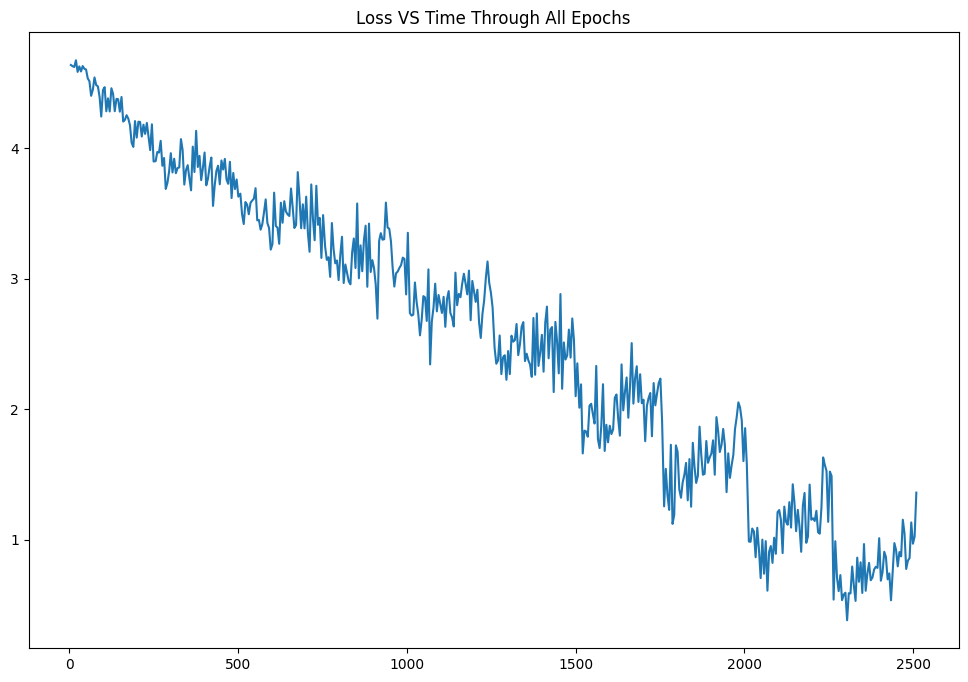

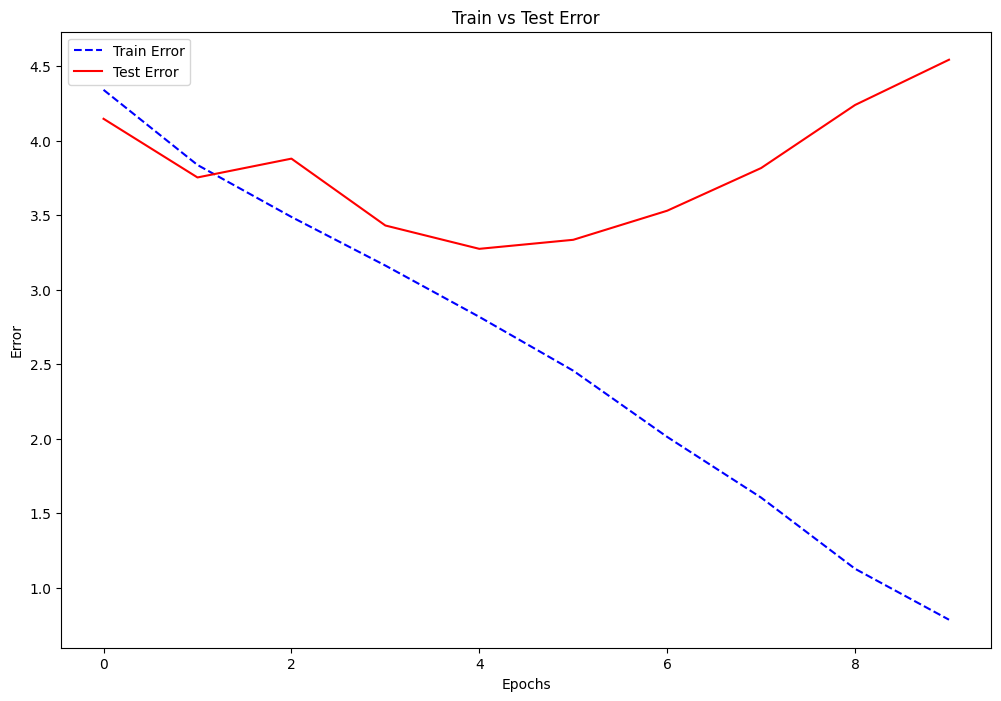


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.580469608306885
4.682445049285889
4.829070091247559
4.831141948699951
4.781445503234863
4.586727619171143
4.55360746383667
4.4665632247924805
4.566889762878418
4.517219066619873
4.415555000305176
4.696938514709473
4.599401473999023
4.310713768005371
4.461679458618164
4.530118942260742
4.354546546936035
4.357994079589844
4.096602439880371
4.521852970123291
4.4415998458862305
4.382272720336914
4.171022415161133
4.176631927490234
4.428770065307617
4.2936930656433105
3.9968600273132324
4.277890205383301
4.163173675537109
4.178057670593262
4.485505104064941
4.316938400268555
4.372124195098877
4.274341583251953
4.26791524887085
3.945530652999878
4.115314960479736
4.675552845001221
4.4961838722229
4.249225616455078
3.911895751953125
4.2081170082092285
4.1892523765563965
4.030206680297852
4.155982494354248
4.462742328643799
3.9683284759521484
4.096038818359375
3.576068639755249
4.028047561645508
█▄3.8872499465942383
3.5009379386901855
4.005785942077637
3.5265398025512695
3.9668807

### Results: 

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.20
Precision: 0.23
Recall: 0.20
F1 Score: 0.19




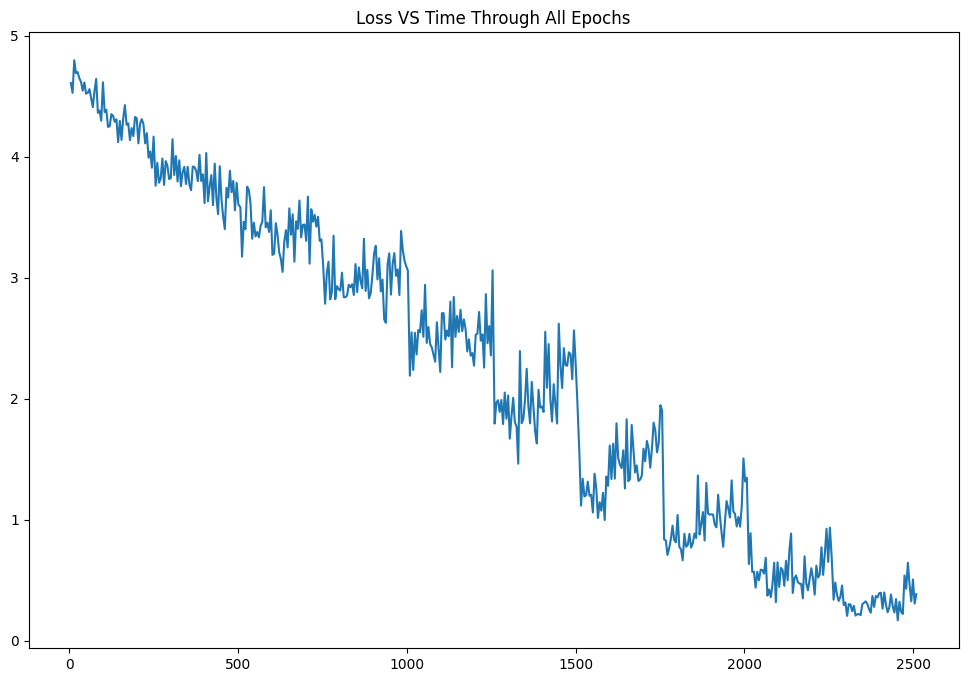

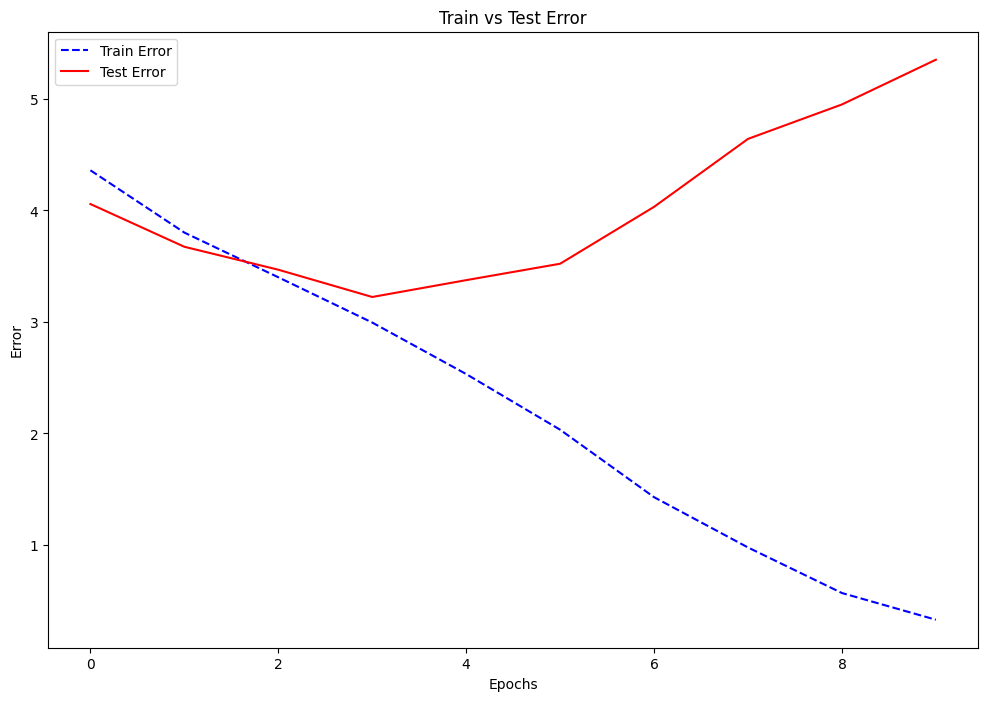


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.611968994140625
4.598917484283447
4.603476524353027
4.5921220779418945
4.602016448974609
4.6031904220581055
4.6150054931640625
4.6039228439331055
4.613246917724609
4.587575912475586
4.615459442138672
4.611285209655762
4.613702774047852
4.591322422027588
4.600571155548096
4.607821941375732
4.606383323669434
4.606809139251709
4.5991291999816895
4.612515449523926
4.614255905151367
4.612864971160889
4.601383209228516
4.592123031616211
4.613386631011963
4.61444091796875
4.616288661956787
4.608783721923828
4.614416122436523
4.5907087326049805
4.606998443603516
4.621456146240234
4.605731010437012
4.590814113616943
4.615849494934082
4.603492736816406
4.573300361633301
4.6352033615112305
4.632163047790527
4.594194412231445
4.635926246643066
4.55217170715332
4.513404846191406
4.518272399902344
4.641437530517578
4.616869926452637
4.528512954711914
4.569888591766357
4.586085319519043
4.625018119812012
█▄4.520121097564697
4.462823390960693
4.464656352996826
4.418233871459961
4.63077878

### Results: 

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
Accuracy: 0.09
Precision: 0.09
Recall: 0.09
F1 Score: 0.08




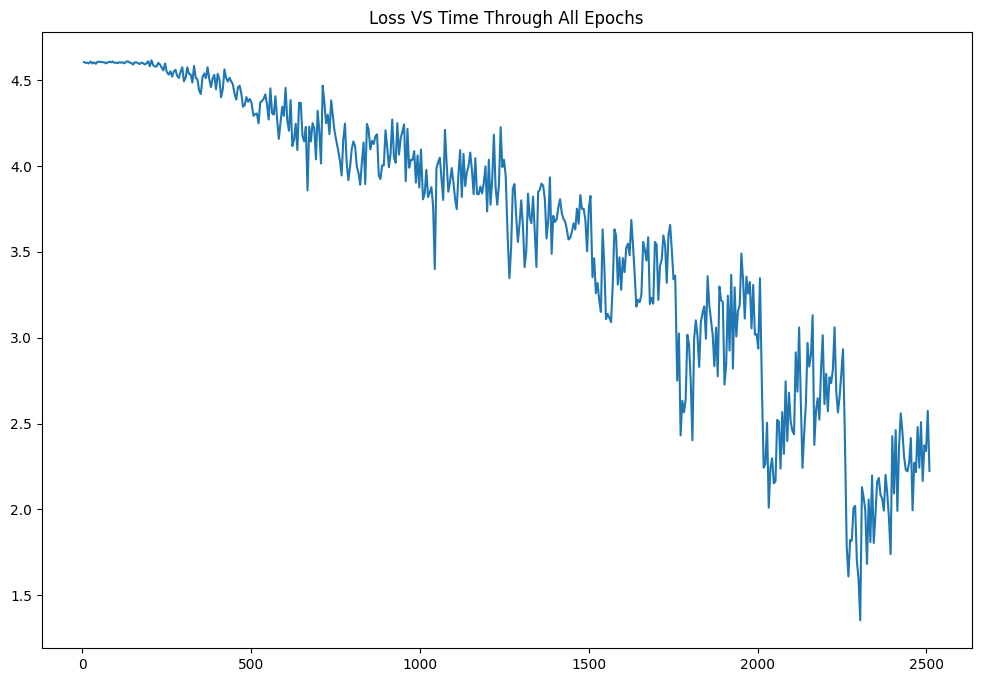

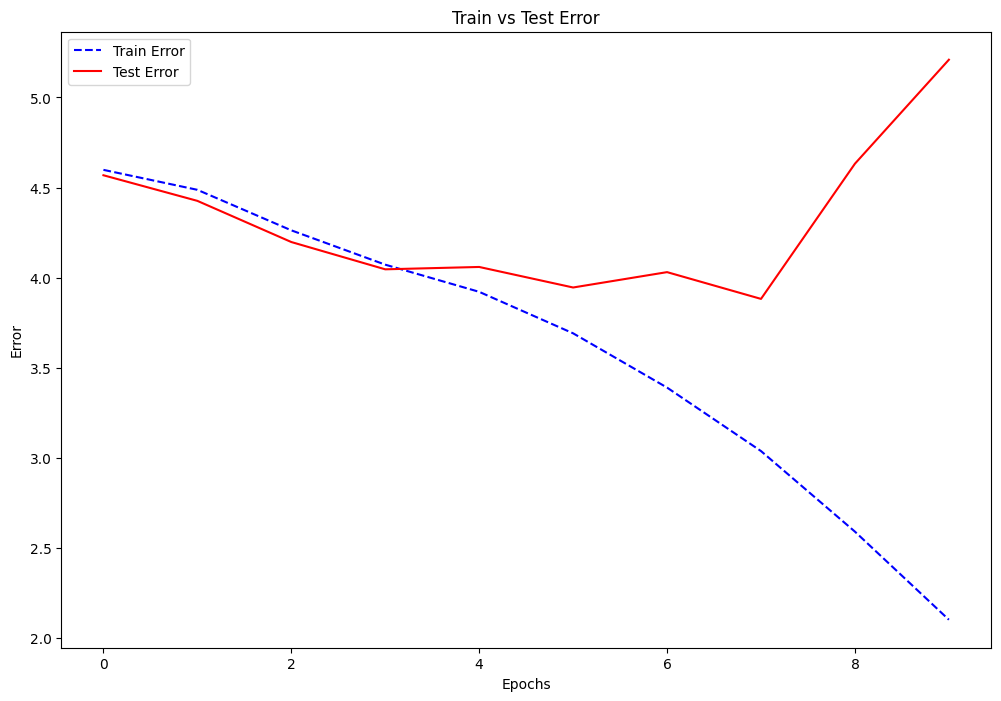


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.591454029083252
4.602180480957031
4.636958599090576
4.586752414703369
4.612217903137207
4.573997497558594
4.635939121246338
4.67356014251709
4.5945634841918945
4.623301029205322
4.490817546844482
4.519644737243652
4.399109363555908
4.535975456237793
4.478781700134277
4.605874061584473
4.356501579284668
4.551208019256592
4.291808128356934
4.3773651123046875
4.290167331695557
4.35170841217041
4.4033918380737305
4.26348876953125
4.351138114929199
4.191446781158447
3.93804669380188
4.257165908813477
4.0071916580200195
4.287860870361328
4.03546667098999
4.476181507110596
4.287900447845459
4.284010887145996
3.993439197540283
4.3079915046691895
3.9321465492248535
4.044248580932617
4.091282844543457
3.7378342151641846
4.153449535369873
4.4908366203308105
4.274535179138184
3.8202719688415527
3.9233522415161133
4.190649509429932
4.375973701477051
3.509150505065918
4.065614700317383
3.7184360027313232
█▄3.7880375385284424
4.029552459716797
3.7468645572662354
3.487489700317383
3.60220

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.24
Precision: 0.29
Recall: 0.24
F1 Score: 0.24




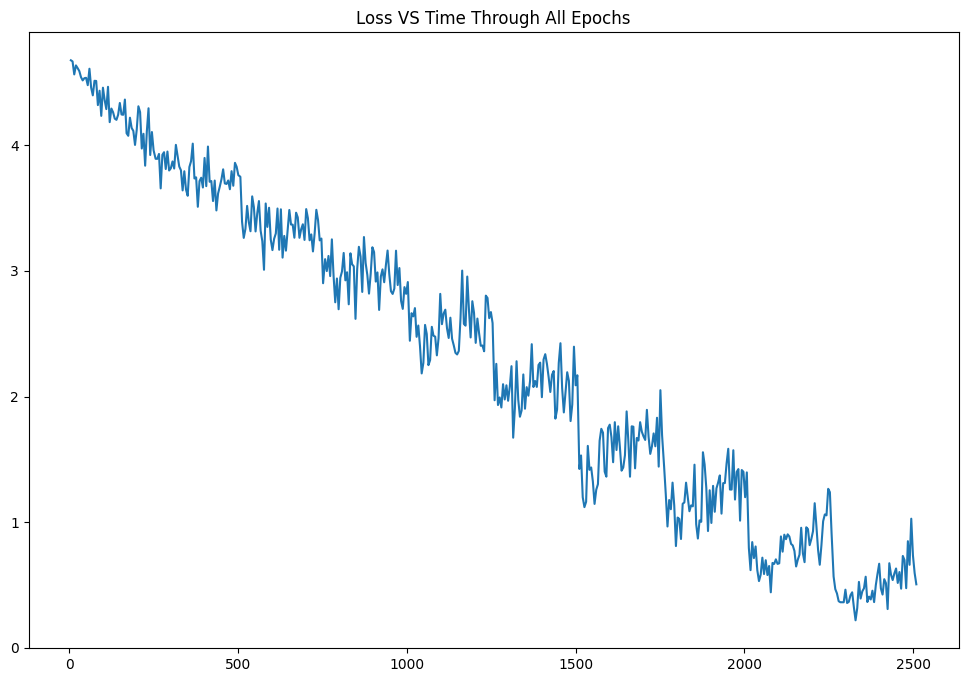

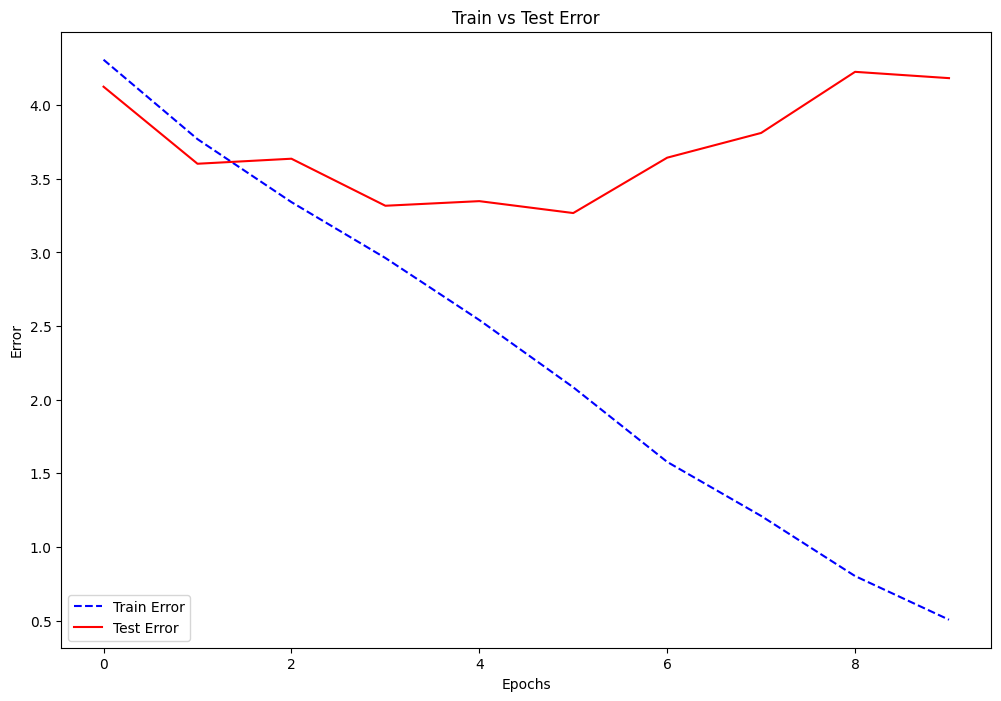


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.698442459106445
4.464322090148926
4.801140785217285
4.486885070800781
4.762531280517578
4.403876781463623
4.678504943847656
4.3161115646362305
4.540588855743408
4.485321044921875
4.392026901245117
4.601016998291016
4.384220123291016
4.323230743408203
4.634923934936523
4.469661712646484
4.5330305099487305
4.010524272918701
4.495415687561035
4.586208820343018
4.431488990783691
4.138663291931152
4.31021785736084
4.4773945808410645
4.120413303375244
4.197105407714844
4.189104080200195
4.1295552253723145
4.152533054351807
4.255098342895508
4.438872814178467
4.010059356689453
4.141767501831055
4.181472301483154
4.268760681152344
4.179817199707031
3.940941333770752
4.297025680541992
4.372141361236572
4.036431312561035
3.7978713512420654
3.8318371772766113
4.058332443237305
3.548657178878784
4.103658676147461
4.055403709411621
3.360543727874756
3.8614156246185303
4.1390700340271
3.786590337753296
█▄3.73368501663208
3.8021178245544434
3.6742329597473145
3.677180051803589
3.87980103

### Results: 

Confusion Matrix:
[[2 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.20
Precision: 0.22
Recall: 0.20
F1 Score: 0.18




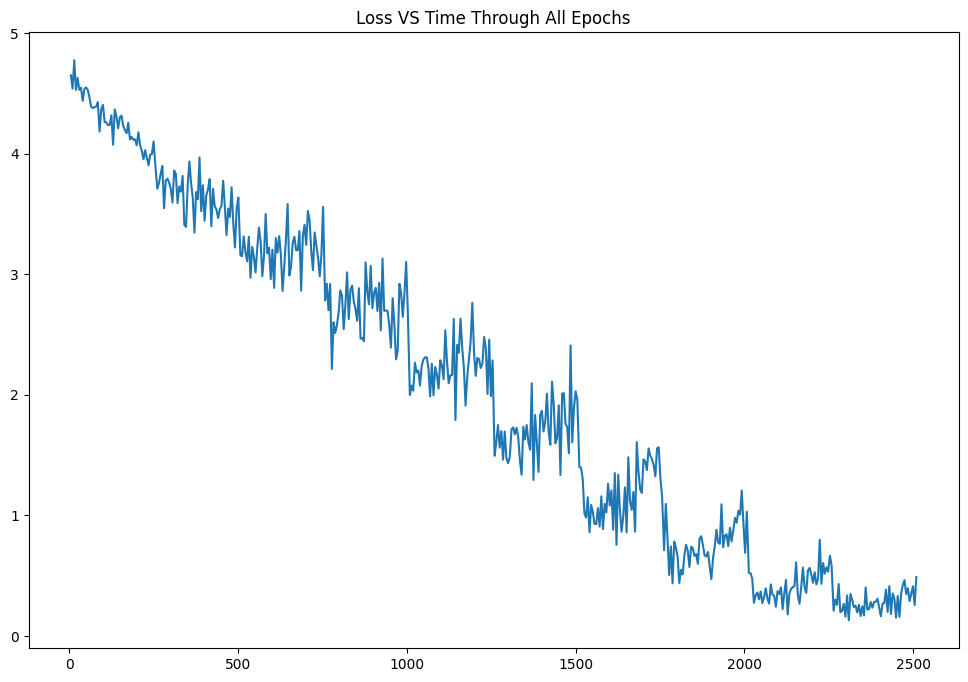

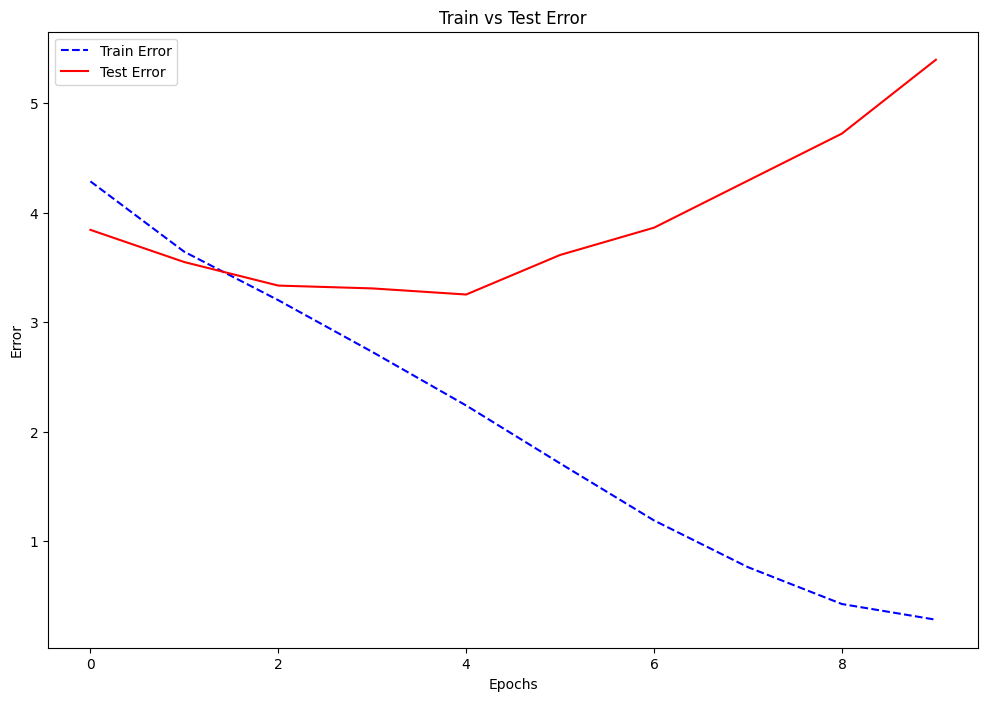


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.598482131958008
4.603995323181152
4.6023030281066895
4.591555595397949
4.614974021911621
4.617332458496094
4.6139140129089355
4.594274520874023
4.605536460876465
4.595366477966309
4.618579864501953
4.589555263519287
4.609716892242432
4.621038436889648
4.598668098449707
4.596754550933838
4.601200103759766
4.611093521118164
4.607558727264404
4.616119384765625
4.606850624084473
4.595402717590332
4.600687026977539
4.60322380065918
4.600876808166504
4.601714134216309
4.612622261047363
4.613317966461182
4.611145973205566
4.607219696044922
4.600881099700928
4.606289863586426
4.597947120666504
4.59832239151001
4.622724533081055
4.603071212768555
4.614699840545654
4.607099533081055
4.604975700378418
4.610119819641113
4.607698917388916
4.619442462921143
4.615022659301758
4.6097822189331055
4.606948375701904
4.617950916290283
4.596128940582275
4.611035346984863
4.599545478820801
4.614311218261719
█▄4.6013569831848145
4.603425979614258
4.599978446960449
4.611970901489258
4.59571886062

### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 2]]
Accuracy: 0.12
Precision: 0.12
Recall: 0.12
F1 Score: 0.10




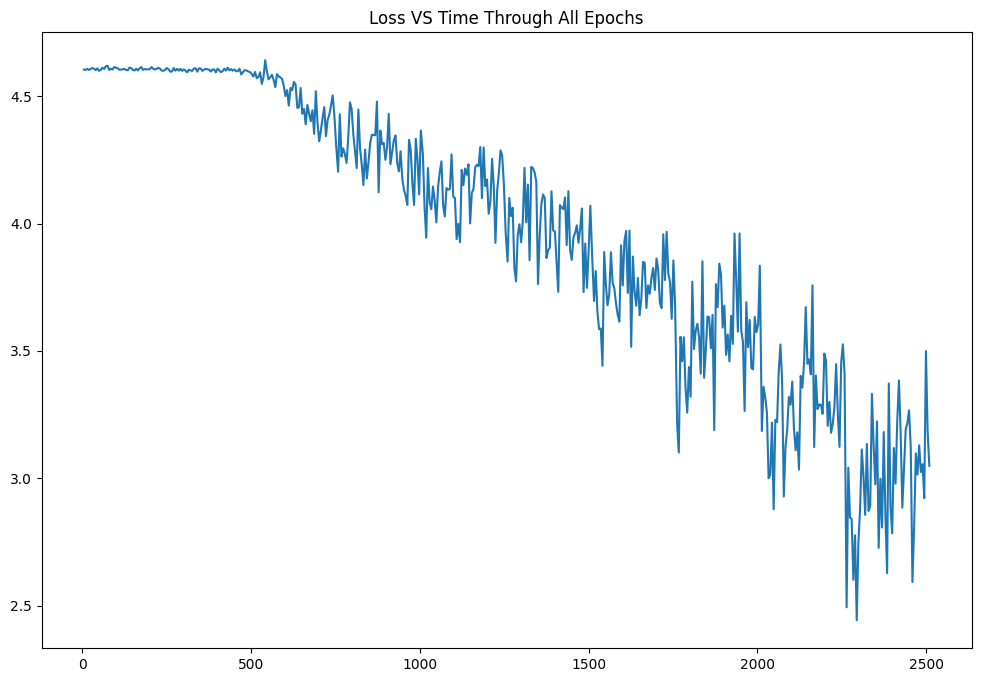

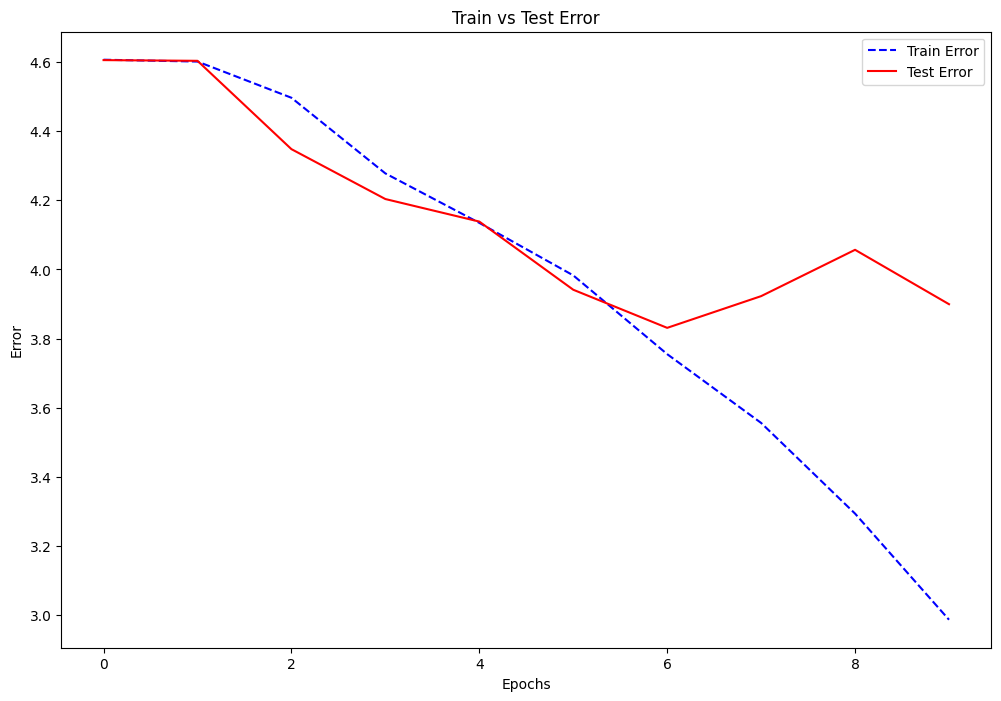


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.639767169952393
4.649409294128418
4.781431674957275
4.687513828277588
4.762805461883545
4.618719100952148
4.617886543273926
4.50832462310791
4.446383476257324
4.587831497192383
4.515746593475342
4.67478084564209
4.4520182609558105
4.518611907958984
4.2739691734313965
4.293112754821777
4.245060920715332
4.3536834716796875
4.401036262512207
4.705857276916504
4.075272560119629
4.267986297607422
4.067554473876953
4.326770305633545
3.985560894012451
3.846982002258301
4.003584384918213
4.050047874450684
4.19419002532959
4.223396301269531
4.014885902404785
4.060029029846191
4.2788848876953125
4.125863075256348
4.398090362548828
4.274256706237793
3.554342269897461
3.866441011428833
3.3021931648254395
4.313996315002441
4.1148271560668945
4.104006767272949
4.0562214851379395
4.309103488922119
4.090505123138428
4.3685407638549805
4.1187825202941895
4.455946922302246
4.044728755950928
3.900954246520996
█▄3.705085039138794
3.7167296409606934
3.9387075901031494
3.667780876159668
4.38589

### Results: 

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]]
Accuracy: 0.32
Precision: 0.37
Recall: 0.32
F1 Score: 0.31




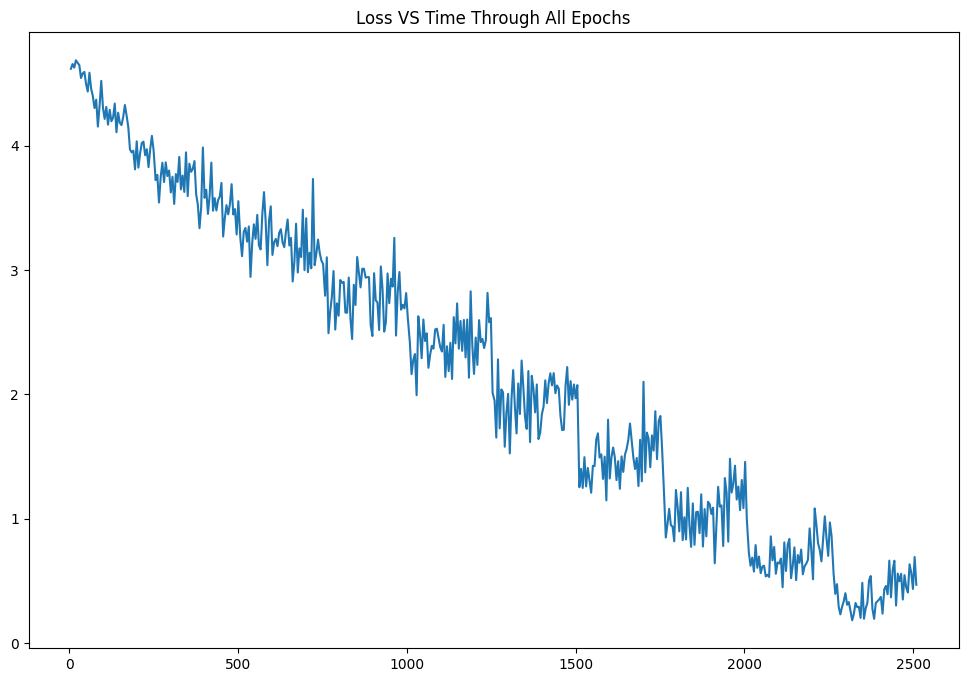

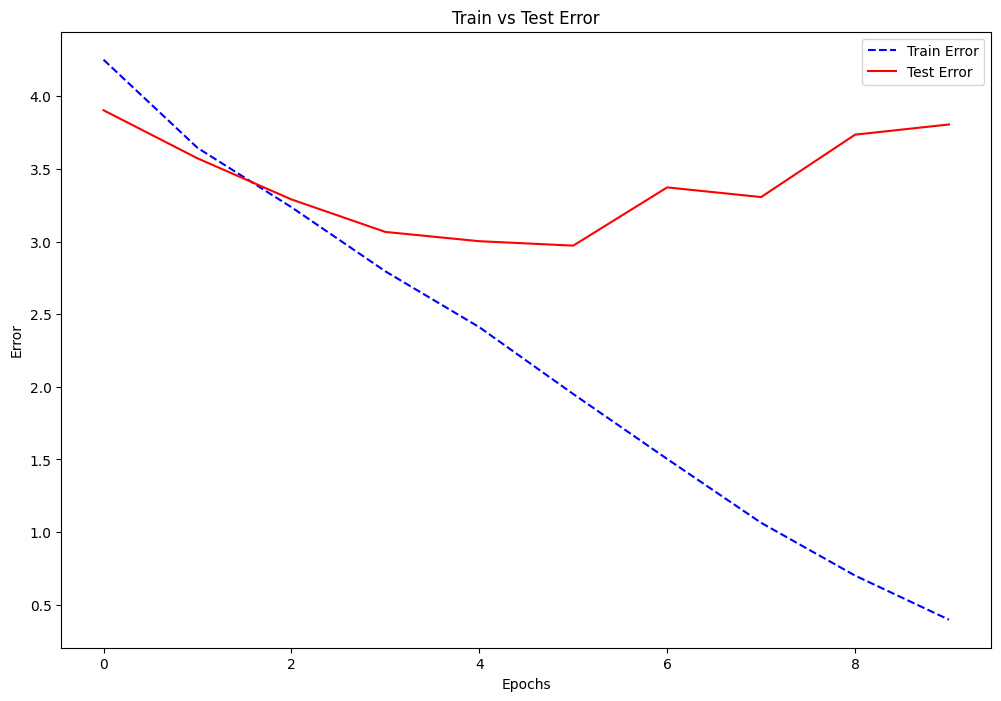


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.690258026123047
4.945835590362549
4.940694332122803
4.513139247894287
4.604913234710693
4.828901767730713
4.386541843414307
4.568314552307129
4.181291103363037
4.417953014373779
4.27488374710083
4.431718826293945
4.417594909667969
4.489633083343506
4.473944664001465
4.236185073852539
4.262263298034668
4.347566604614258
4.219934940338135
4.148745536804199
4.113271713256836
4.140901565551758
3.852123260498047
4.511639595031738
4.603306293487549
4.237430572509766
4.371645450592041
4.343930244445801
4.155879020690918
3.7299869060516357
3.884674549102783
4.305842399597168
3.7190165519714355
3.71856689453125
4.465097904205322
4.2273454666137695
4.122584342956543
3.6974620819091797
4.3480730056762695
4.255014896392822
4.271533012390137
4.521903038024902
4.45015287399292
3.90801739692688
3.03249454498291
4.080242156982422
3.637478828430176
3.952498435974121
3.9832794666290283
3.830334186553955
█▄3.9550023078918457
3.6347997188568115
3.841625213623047
3.606328010559082
4.0011038780

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.25
Precision: 0.26
Recall: 0.25
F1 Score: 0.23




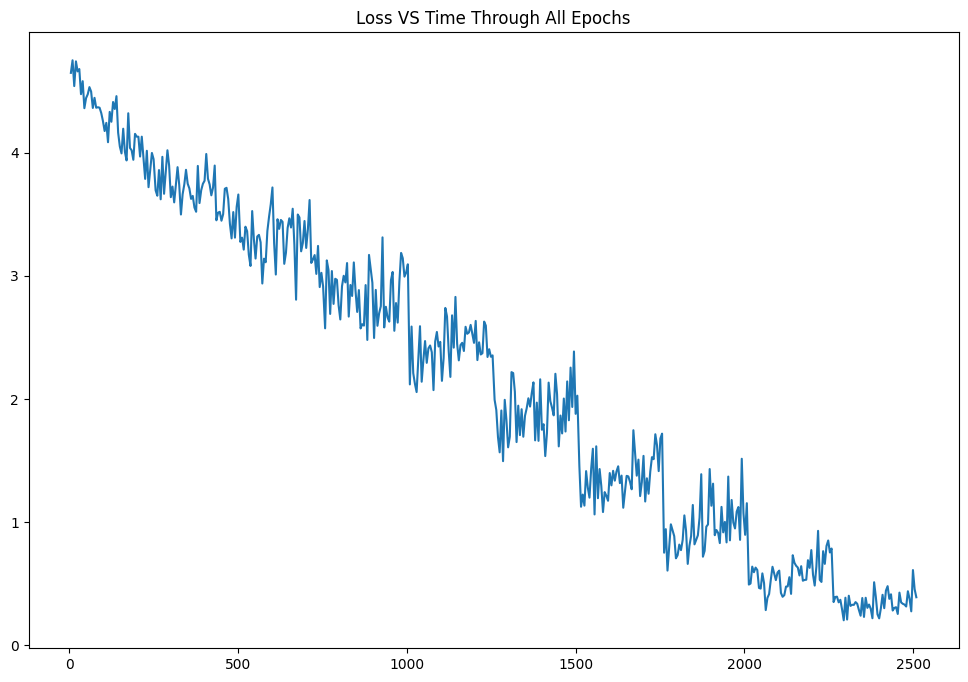

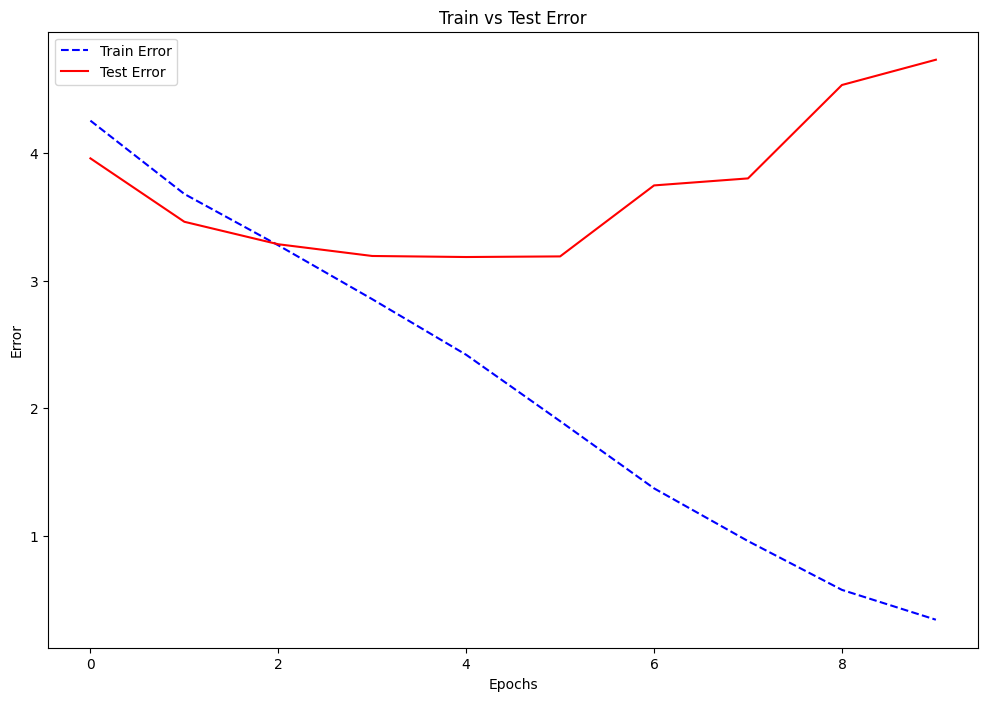


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.609463691711426
4.601709842681885
4.604717254638672
4.617617607116699
4.611792087554932
4.600699424743652
4.59660005569458
4.603243827819824
4.6054511070251465
4.603912353515625
4.600050926208496
4.601747035980225
4.598146438598633
4.599668979644775
4.602803707122803
4.593451499938965
4.607115745544434
4.615206241607666
4.6049485206604
4.616930961608887
4.607354164123535
4.605466842651367
4.605634689331055
4.5979437828063965
4.5977582931518555
4.608125686645508
4.595944404602051
4.607965469360352
4.600404739379883
4.609114170074463
4.604135513305664
4.587263107299805
4.608386039733887
4.606419563293457
4.590292930603027
4.625823974609375
4.586620330810547
4.604725360870361
4.609376907348633
4.598893642425537
4.607034683227539
4.586470603942871
4.60056209564209
4.628958702087402
4.589171409606934
4.590117931365967
4.625711917877197
4.590893745422363
4.597681999206543
4.585433006286621
█▄4.588388442993164
4.584469318389893
4.582951545715332
4.552724838256836
4.57314634323120

### Results: 

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.14
Precision: 0.13
Recall: 0.14
F1 Score: 0.12




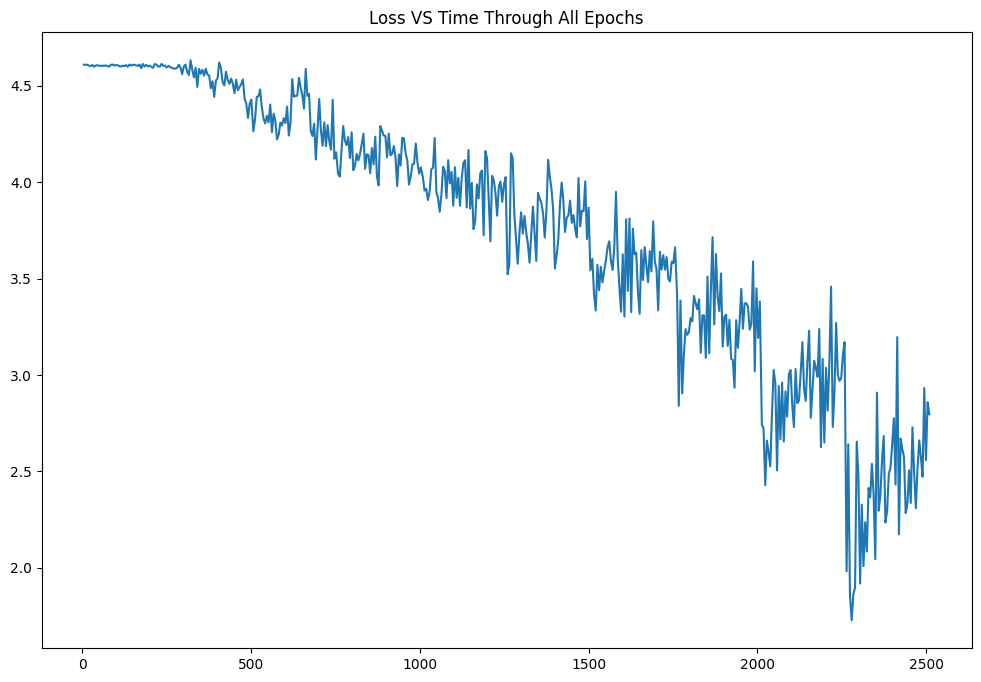

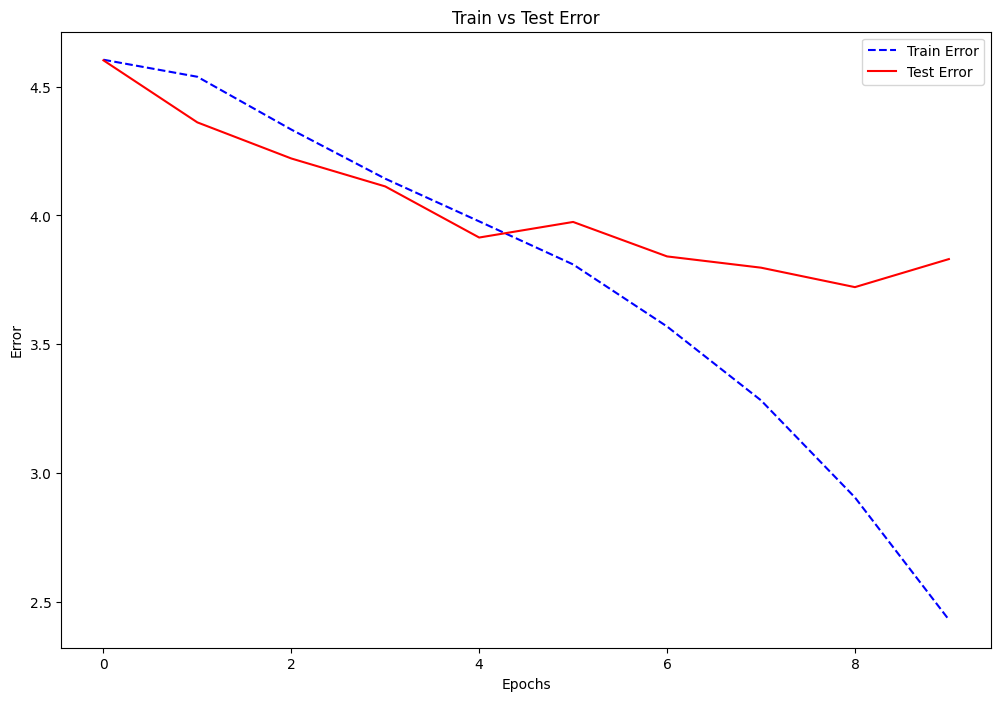


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.6862006187438965
4.769559860229492
4.862719535827637
4.586640357971191
4.735631942749023
4.5528717041015625
4.600244045257568
4.5329742431640625
4.569616317749023
4.382602214813232
4.3245649337768555
4.378787040710449
4.538535118103027
4.597818851470947
4.277241230010986
4.526442527770996
4.270831108093262
4.5968170166015625
4.56532621383667
4.498156547546387
4.2108235359191895
4.354766368865967
3.8985133171081543
4.3777875900268555
4.648496627807617
4.258089065551758
4.148256778717041
3.9927854537963867
4.235617637634277
4.182551383972168
4.094850063323975
3.6815054416656494
4.3417582511901855
4.069281578063965
4.006904602050781
4.2169060707092285
4.038432598114014
4.253381252288818
3.908580780029297
4.188530445098877
4.210795879364014
3.903719186782837
4.104475021362305
3.679307460784912
4.167628765106201
3.987764835357666
3.59365177154541
3.8484904766082764
3.641937494277954
3.8576912879943848
█▄3.600667953491211
3.9540977478027344
4.032175540924072
3.6898255348205566
3

### Results: 

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 3]]
Accuracy: 0.32
Precision: 0.35
Recall: 0.32
F1 Score: 0.29




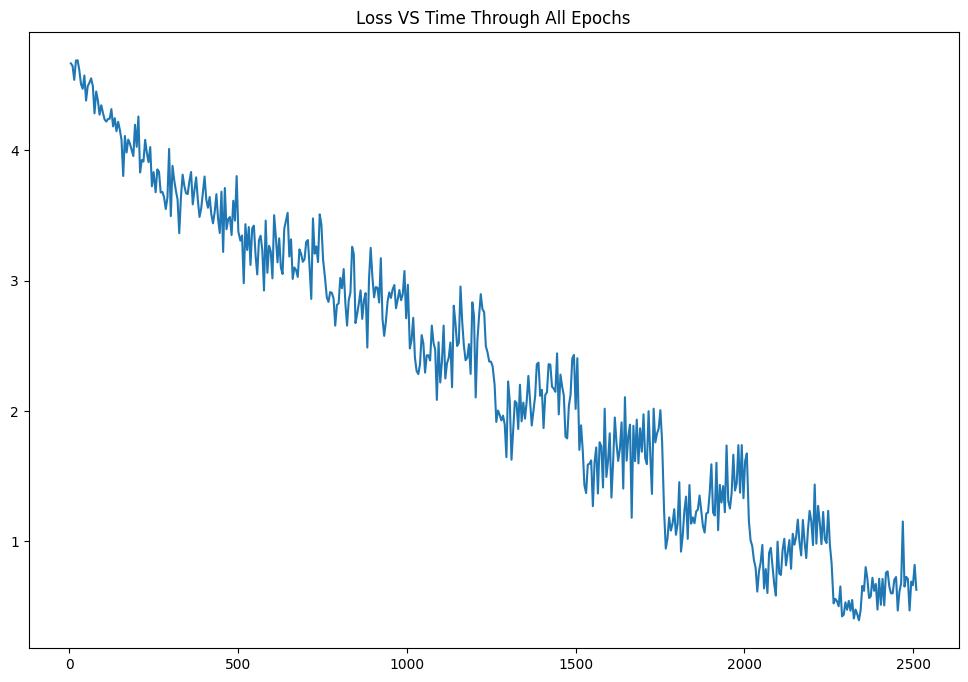

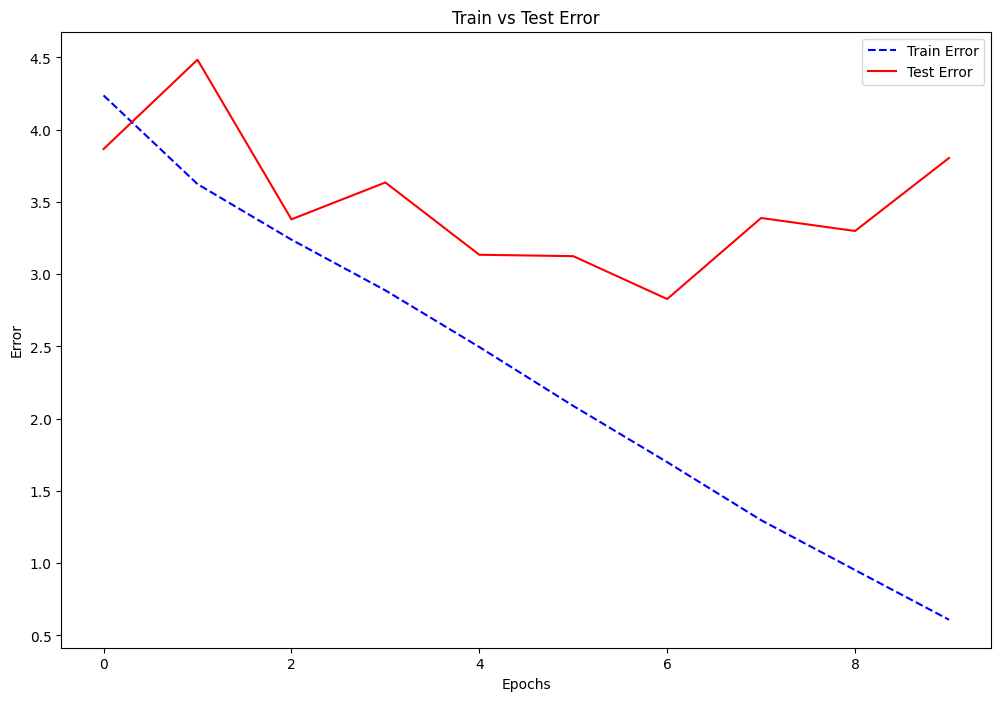


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.6551666259765625
4.710779666900635
4.802695274353027
4.804873943328857
4.610684394836426
4.646312236785889
4.505607604980469
4.388216972351074
4.322943210601807
4.454161167144775
4.466410160064697
4.265305519104004
4.235369682312012
3.941629648208618
4.257758617401123
4.601644992828369
4.217412948608398
4.77430534362793
4.020016193389893
4.471773147583008
3.9784927368164062
4.204977035522461
4.46617317199707
4.273471355438232
4.270360946655273
4.051889896392822
4.330033302307129
3.9012880325317383
4.246534824371338
4.3437652587890625
4.093701362609863
4.301552772521973
4.536248683929443
3.5792737007141113
3.8737175464630127
4.319340229034424
4.313163757324219
4.192418098449707
4.251248836517334
4.189467906951904
4.418020248413086
3.8363285064697266
3.891857624053955
4.050000190734863
3.7199764251708984
4.425852298736572
3.4956607818603516
4.189511775970459
3.719736099243164
4.003735542297363
█▄4.126987934112549
3.665618896484375
3.480055332183838
3.540602445602417
3.109953

### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.25
Precision: 0.28
Recall: 0.25
F1 Score: 0.23




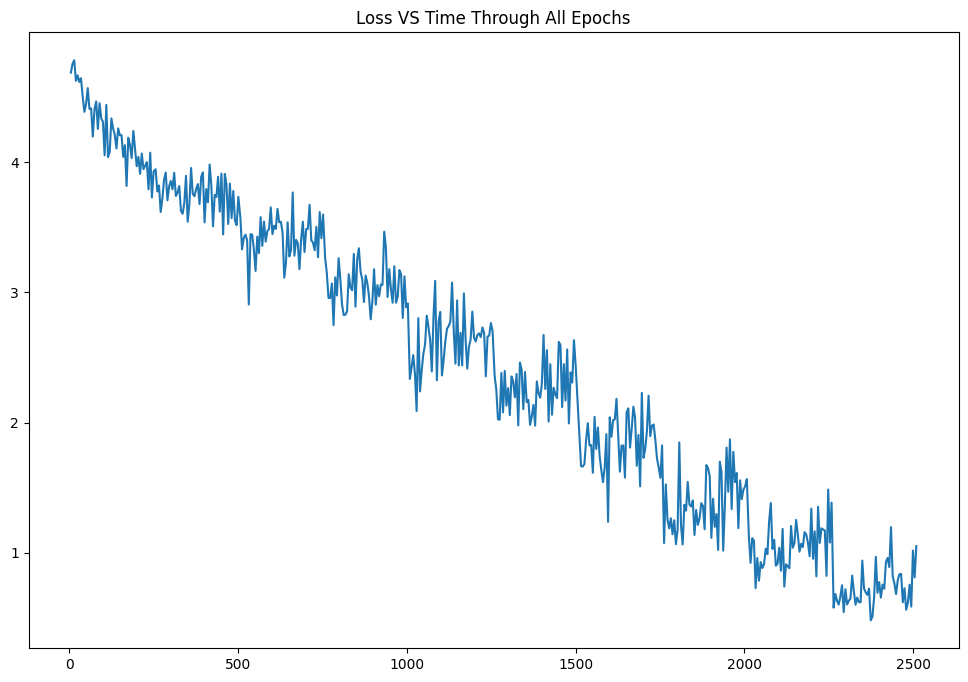

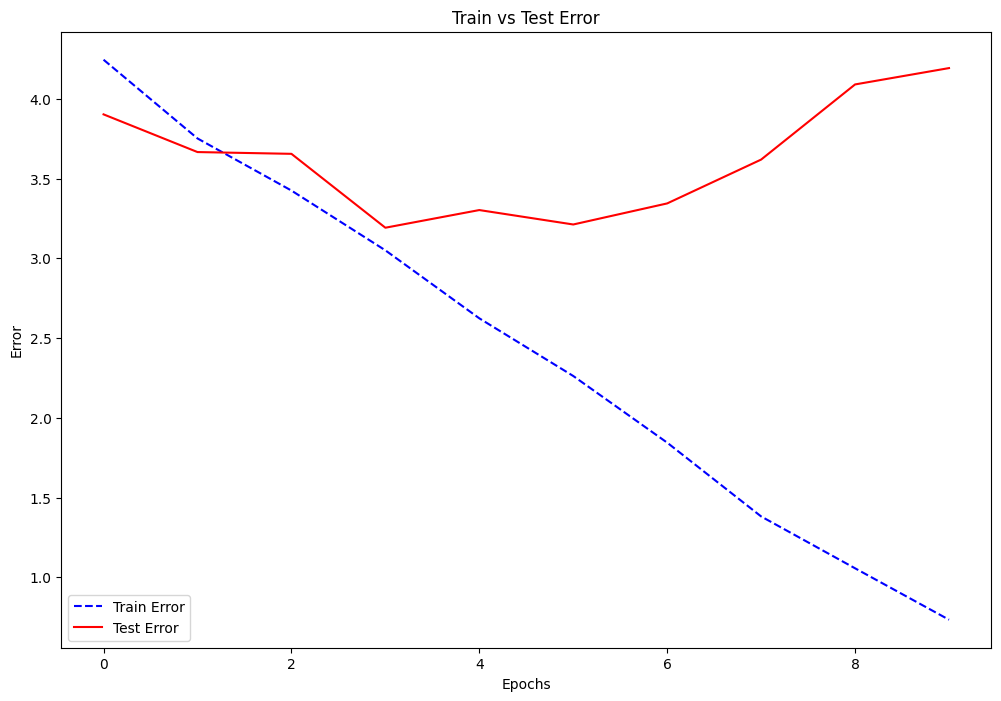


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 16
- Epoch Count: 10
    

Training..
4.6075897216796875
4.583770751953125
4.614971160888672
4.625576019287109
4.617101669311523
4.614584922790527
4.611215114593506
4.614969730377197
4.586503982543945
4.6068525314331055
4.596678733825684
4.598565101623535
4.598700523376465
4.5990214347839355
4.592063903808594
4.604677677154541
4.615990161895752
4.603589057922363
4.612975120544434
4.610293388366699
4.613068103790283
4.61161994934082
4.609847545623779
4.589400768280029
4.610962867736816
4.608970642089844
4.603828430175781
4.617334365844727
4.611201286315918
4.603940486907959
4.600130558013916
4.617561340332031
4.6200056076049805
4.622152805328369
4.603452682495117
4.604123592376709
4.604518413543701
4.628619194030762
4.607446193695068
4.594961166381836
4.597893714904785
4.602550983428955
4.6072282791137695
4.607131481170654
4.5885114669799805
4.621274948120117
4.611013412475586
4.604760646820068
4.604170799255371
4.601805210113525
█▄4.59433650970459
4.59800386428833
4.618618011474609
4.599151611328125
4.5607023239

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.14
Precision: 0.13
Recall: 0.14
F1 Score: 0.12




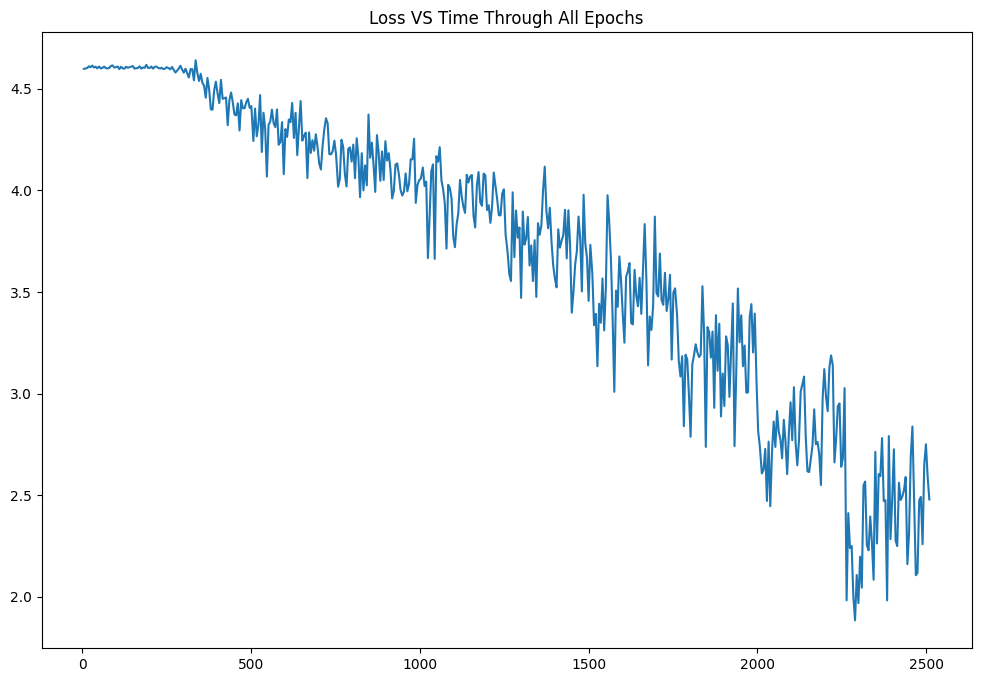

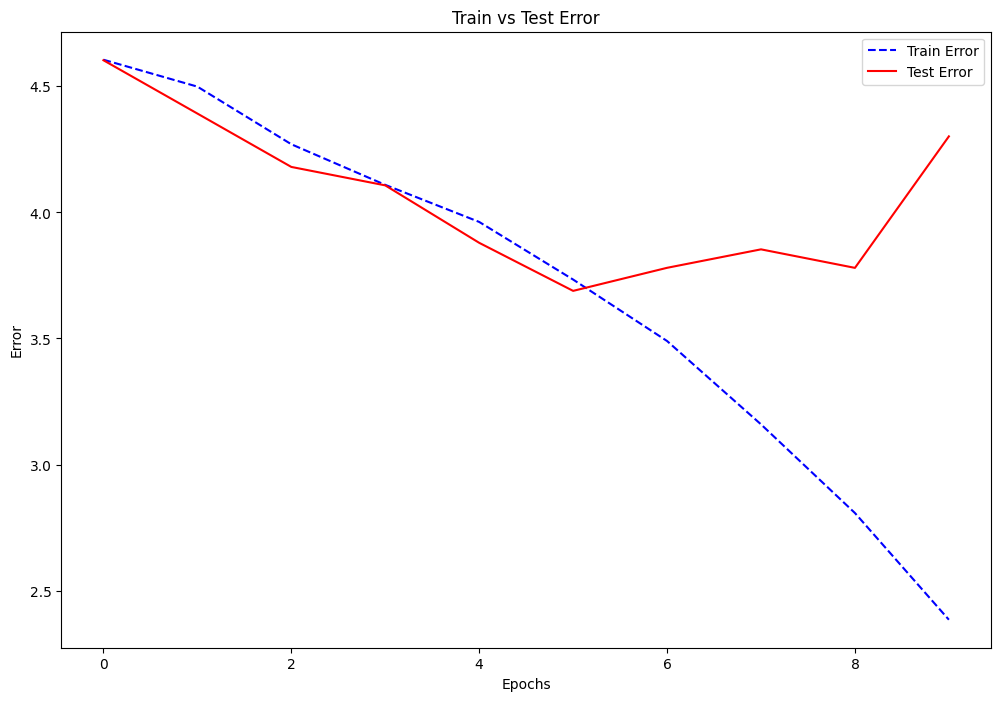


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.6375250816345215
4.606085777282715
4.644793510437012
4.582231521606445
4.586000442504883
4.561173915863037
4.5908942222595215
4.576761245727539
4.542736530303955
4.576528549194336
4.5223798751831055
4.549860954284668
4.580042839050293
4.458234786987305
4.5366339683532715
4.436878681182861
4.4427947998046875
4.412538528442383
4.359174728393555
4.415206432342529
4.4953227043151855
4.210338115692139
4.151337623596191
4.281327247619629
4.306429862976074
█▄4.093698501586914
4.449667930603027
4.240914821624756
4.299278259277344
4.110579490661621
4.222174644470215
4.229334831237793
3.8673973083496094
4.099291801452637
4.268335342407227
4.0140180587768555
3.7923731803894043
4.06716251373291
4.281930446624756
4.148836135864258
3.887910842895508
3.7593727111816406
3.9313504695892334
3.6782474517822266
3.9215805530548096
4.0042219161987305
3.8836708068847656
3.9289824962615967
4.1376495361328125
3.629909038543701
█▄3.873870611190796
3.121464252471924
3.96658992767334
3.41370630264282

### Results: 

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.28
Precision: 0.32
Recall: 0.28
F1 Score: 0.26




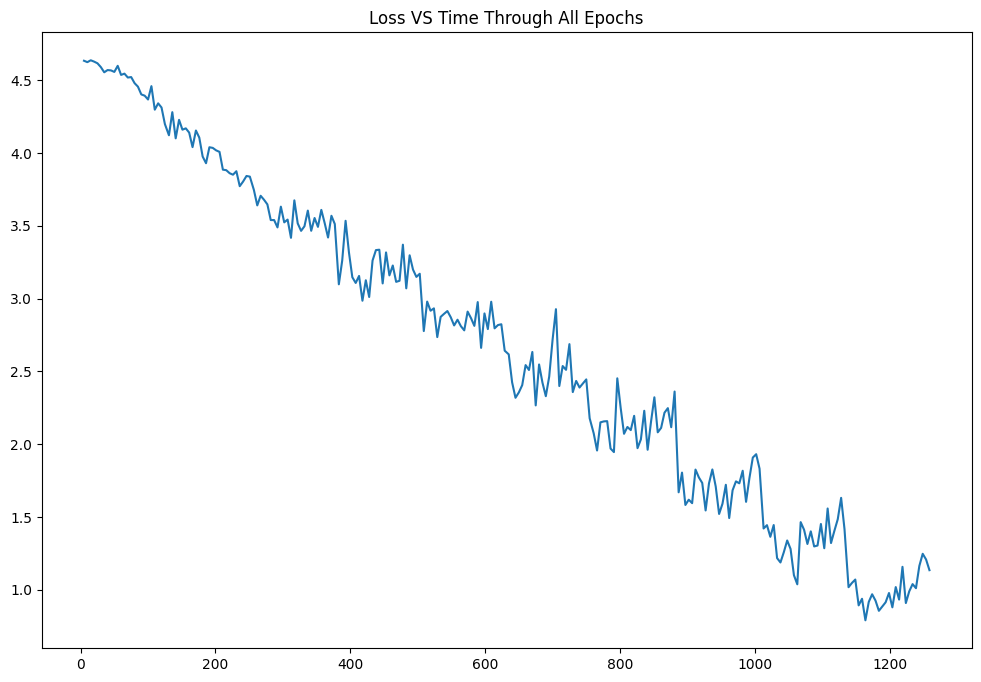

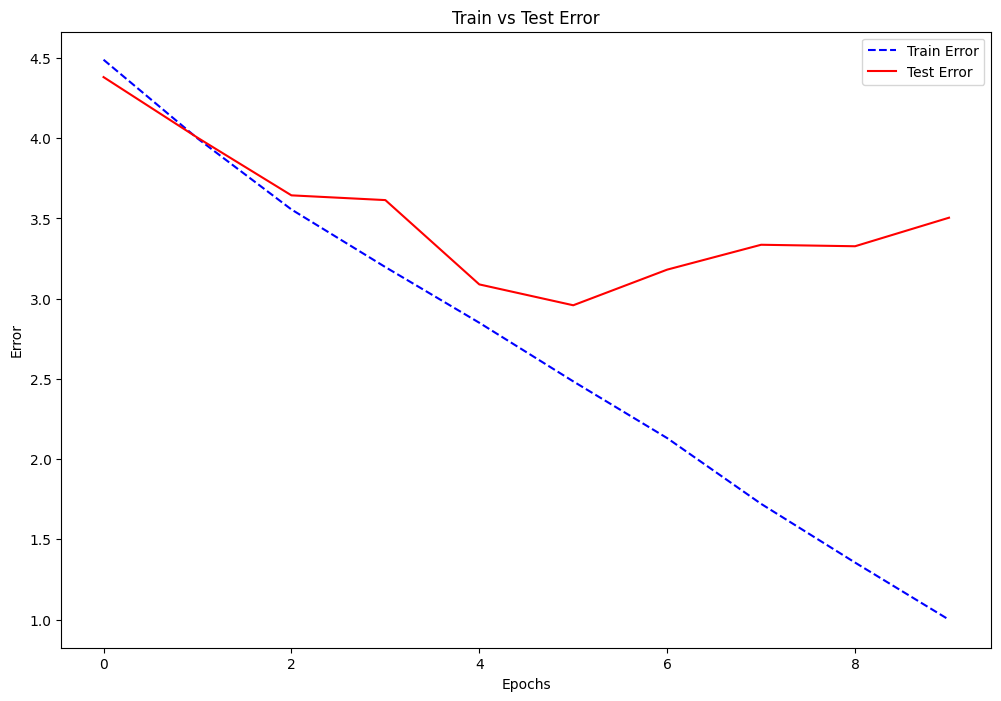


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.647292137145996
4.556644439697266
4.494683265686035
4.695720672607422
4.6692986488342285
4.5993499755859375
4.548025131225586
4.565459728240967
4.583926677703857
4.30074405670166
4.247507572174072
4.227810859680176
4.406599044799805
4.3259382247924805
4.327252388000488
4.27636194229126
4.27212381362915
4.182816028594971
4.0048627853393555
4.269999980926514
4.27227783203125
4.247430801391602
4.3904314041137695
4.152538299560547
3.870832681655884
█▄3.9199674129486084
3.697218894958496
3.6534574031829834
3.640536308288574
3.5729753971099854
3.8755695819854736
3.7667341232299805
3.214639186859131
4.016717910766602
3.8443422317504883
3.398853302001953
3.891356945037842
3.918205738067627
3.774163246154785
3.477943181991577
3.4308090209960938
3.8153703212738037
3.6228408813476562
3.476412534713745
3.71329927444458
3.9732651710510254
4.026876449584961
3.697659492492676
3.321369171142578
3.3821120262145996
█▄3.23563289642334
3.7739593982696533
3.345216751098633
3.5693209171295166
3

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.20
Precision: 0.22
Recall: 0.20
F1 Score: 0.18




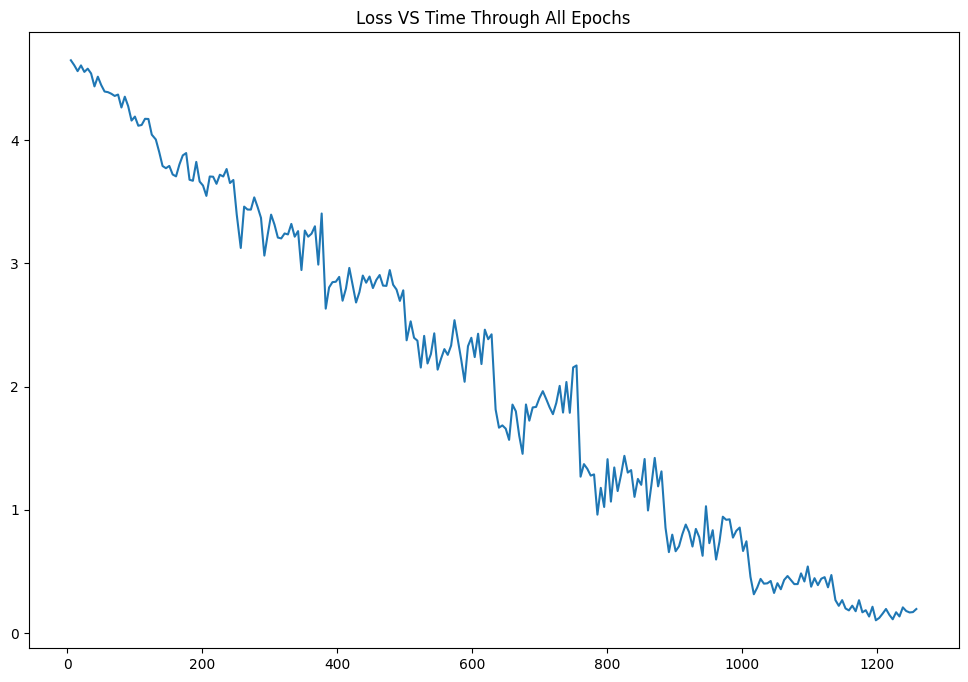

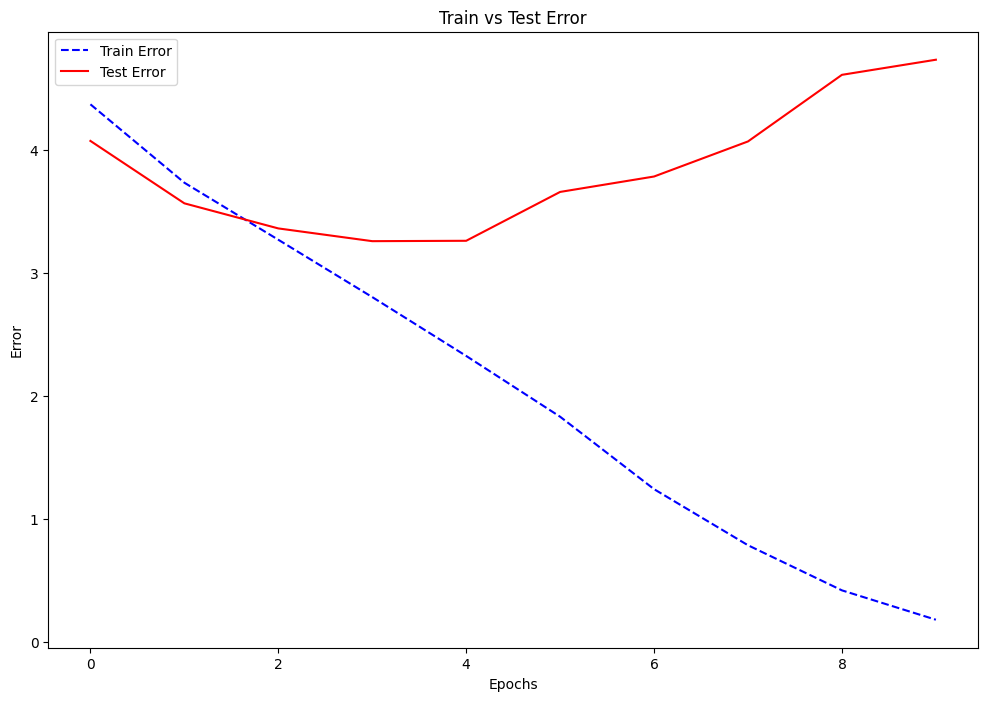


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.612657070159912
4.609861850738525
4.5994415283203125
4.599546432495117
4.612792015075684
4.61467170715332
4.606001853942871
4.593796730041504
4.614604473114014
4.614010334014893
4.603459358215332
4.610748767852783
4.611293792724609
4.598214149475098
4.60112190246582
4.5964250564575195
4.608817100524902
4.601624488830566
4.614501476287842
4.603699684143066
4.612472057342529
4.611322402954102
4.602497100830078
4.6100687980651855
4.608135223388672
█▄4.5992608070373535
4.604681015014648
4.61008358001709
4.59630012512207
4.613404273986816
4.604287147521973
4.596413612365723
4.6250505447387695
4.609354496002197
4.5990519523620605
4.611954212188721
4.606691360473633
4.598739147186279
4.604570388793945
4.60862398147583
4.590054512023926
4.601166248321533
4.600818634033203
4.5986857414245605
4.597688674926758
4.610569000244141
4.618809700012207
4.60354471206665
4.618707656860352
4.601120471954346
█▄4.60073184967041
4.595114231109619
4.602666854858398
4.5980682373046875
4.5984511375

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.08
Precision: 0.06
Recall: 0.08
F1 Score: 0.06




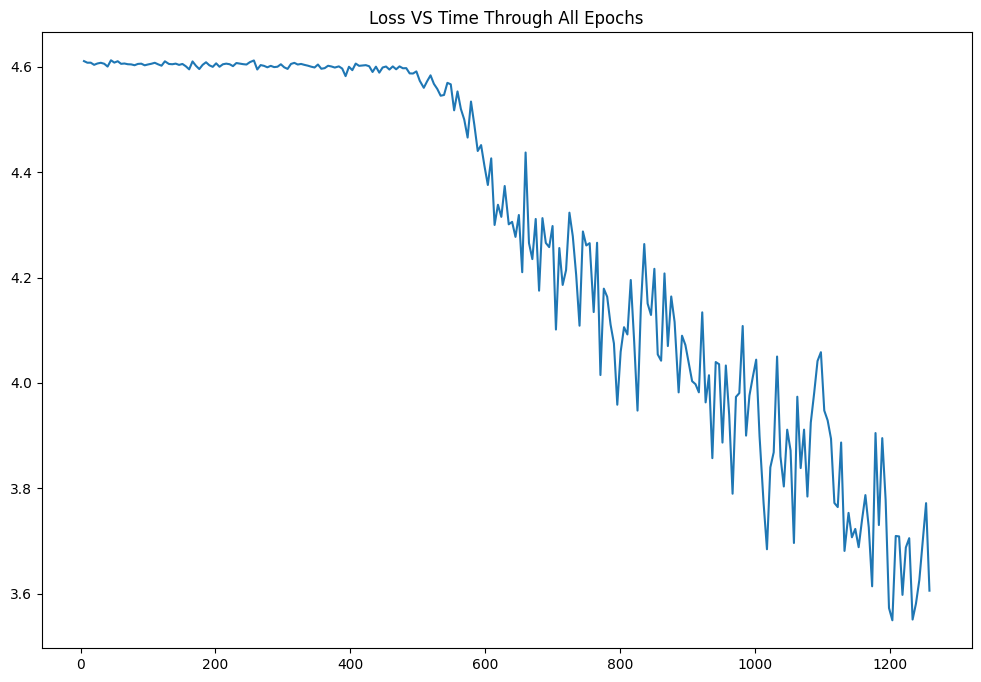

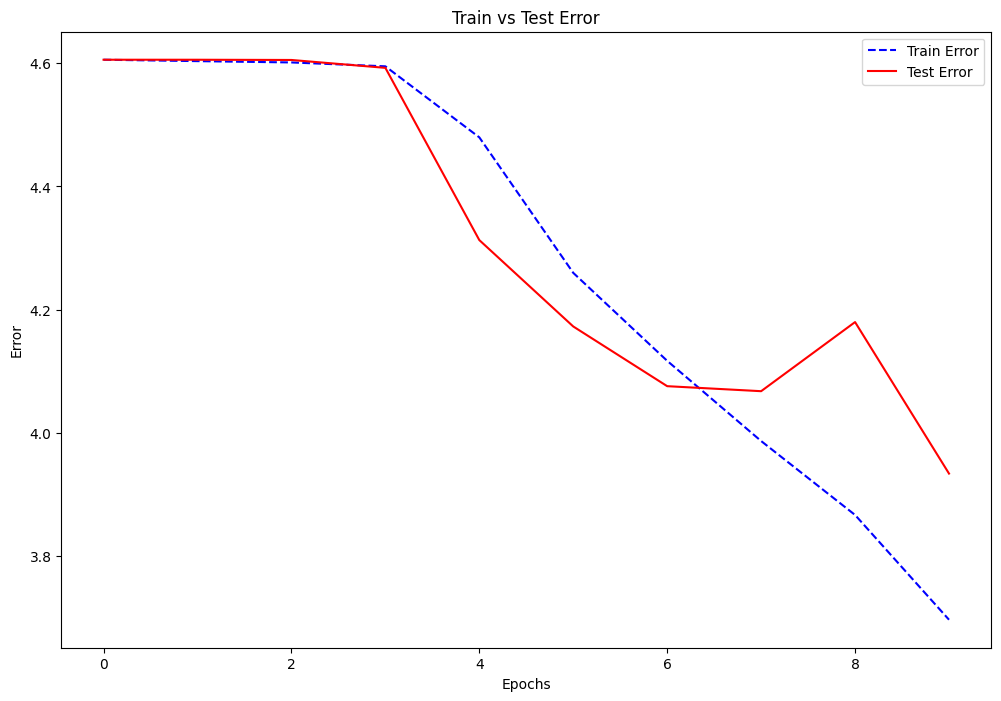


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.65495491027832
4.550782680511475
4.527430057525635
4.545769214630127
4.527805328369141
4.633024215698242
4.529905319213867
4.632828712463379
4.466892242431641
4.442692279815674
4.384171962738037
4.498667240142822
4.3533406257629395
4.302804946899414
4.14591121673584
4.246697425842285
4.210829734802246
4.1765360832214355
4.091115474700928
4.06619930267334
4.373631477355957
4.1198530197143555
4.423072814941406
4.087235927581787
3.987959623336792
█▄3.844287157058716
3.883211135864258
3.9962456226348877
3.813369035720825
4.057600021362305
3.567962169647217
3.7414019107818604
3.841754198074341
3.8275928497314453
3.797760009765625
3.5056850910186768
3.70314359664917
3.913628101348877
4.151113510131836
3.2613978385925293
3.5524840354919434
3.657907009124756
3.910534620285034
3.32820463180542
3.8081905841827393
3.834604263305664
3.592829704284668
3.622809886932373
3.5831611156463623
3.689558982849121
█▄3.4343671798706055
3.277327299118042
3.5627145767211914
3.276115655899048
3.928

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.33
Precision: 0.38
Recall: 0.33
F1 Score: 0.31




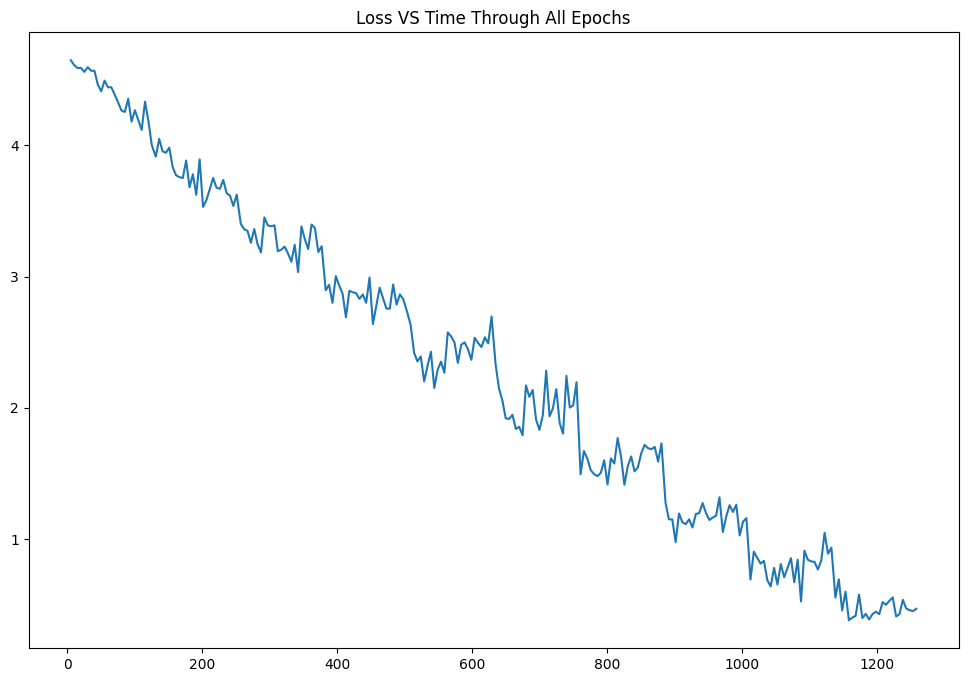

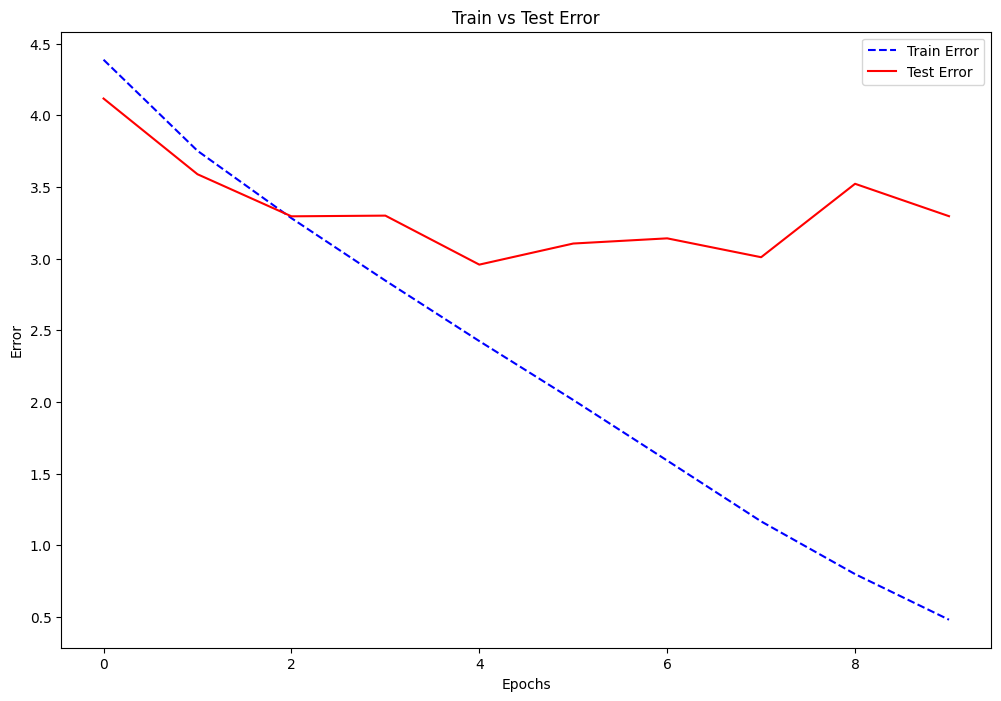


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.630760192871094
4.688156604766846
4.602321624755859
4.7031755447387695
4.579069137573242
4.574541091918945
4.441169738769531
4.322603225708008
4.320154666900635
4.22412109375
4.153815746307373
4.318236351013184
4.0725884437561035
4.200610160827637
4.186196804046631
4.291727066040039
3.8751449584960938
4.05557107925415
3.8667635917663574
3.9816815853118896
3.8630175590515137
3.8915796279907227
4.090983867645264
3.9363059997558594
3.63230299949646
█▄3.6979002952575684
3.744171380996704
3.741297483444214
3.8125200271606445
3.7540247440338135
3.832798957824707
3.760650157928467
3.8322410583496094
3.659435749053955
3.3125085830688477
4.0270586013793945
4.188799858093262
3.6040239334106445
3.3937430381774902
3.2171876430511475
3.65242338180542
3.688260555267334
3.6161372661590576
3.5491485595703125
3.4614315032958984
3.408634662628174
3.292393684387207
3.461455821990967
3.8977670669555664
3.2549428939819336
█▄2.899354934692383
2.8896327018737793
2.7324411869049072
2.814024925231

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.27
Precision: 0.29
Recall: 0.27
F1 Score: 0.25




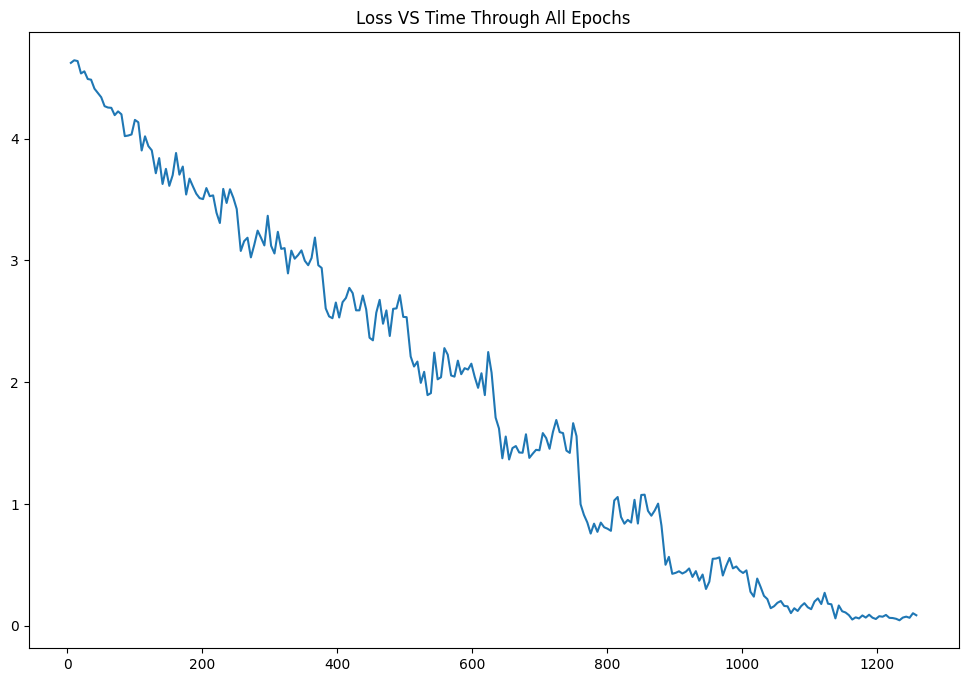

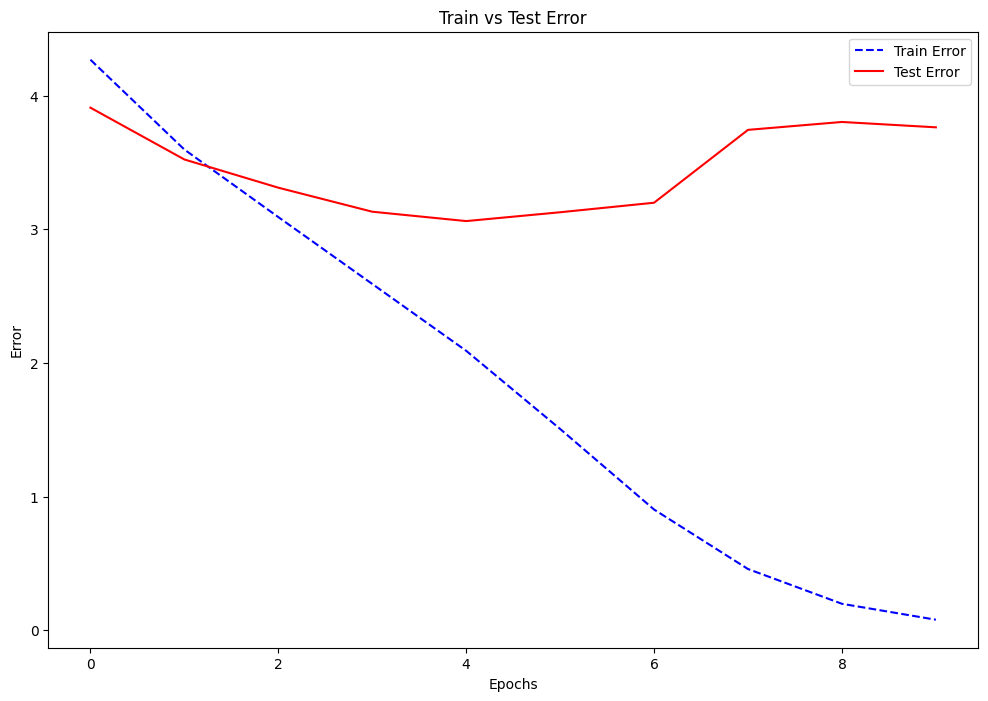


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.599421977996826
4.598967552185059
4.5951128005981445
4.614322185516357
4.605523586273193
4.6086626052856445
4.615387916564941
4.616188049316406
4.613472938537598
4.601743698120117
4.608963966369629
4.602489471435547
4.603884220123291
4.602480411529541
4.6056318283081055
4.604421615600586
4.600627899169922
4.600122451782227
4.601870536804199
4.605991363525391
4.607731819152832
4.610611438751221
4.609680652618408
4.608122825622559
4.603762626647949
█▄4.600765228271484
4.603741645812988
4.607284069061279
4.603306770324707
4.601780414581299
4.604679107666016
4.593087196350098
4.602232933044434
4.605458736419678
4.606634140014648
4.611843109130859
4.612332820892334
4.598852157592773
4.607054233551025
4.598198890686035
4.5997419357299805
4.604686737060547
4.606020450592041
4.608010292053223
4.598827838897705
4.595659255981445
4.603604316711426
4.607189178466797
4.604701042175293
4.6029863357543945
█▄4.595208168029785
4.603062629699707
4.597465515136719
4.599435806274414
4.606232

### Results: 

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.12
Precision: 0.11
Recall: 0.12
F1 Score: 0.09




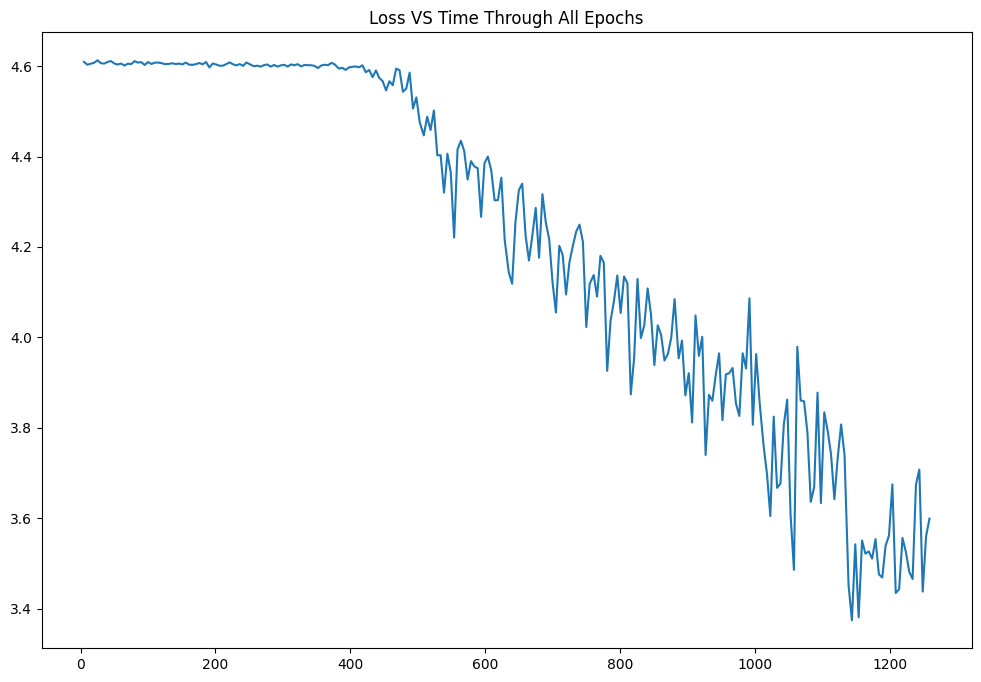

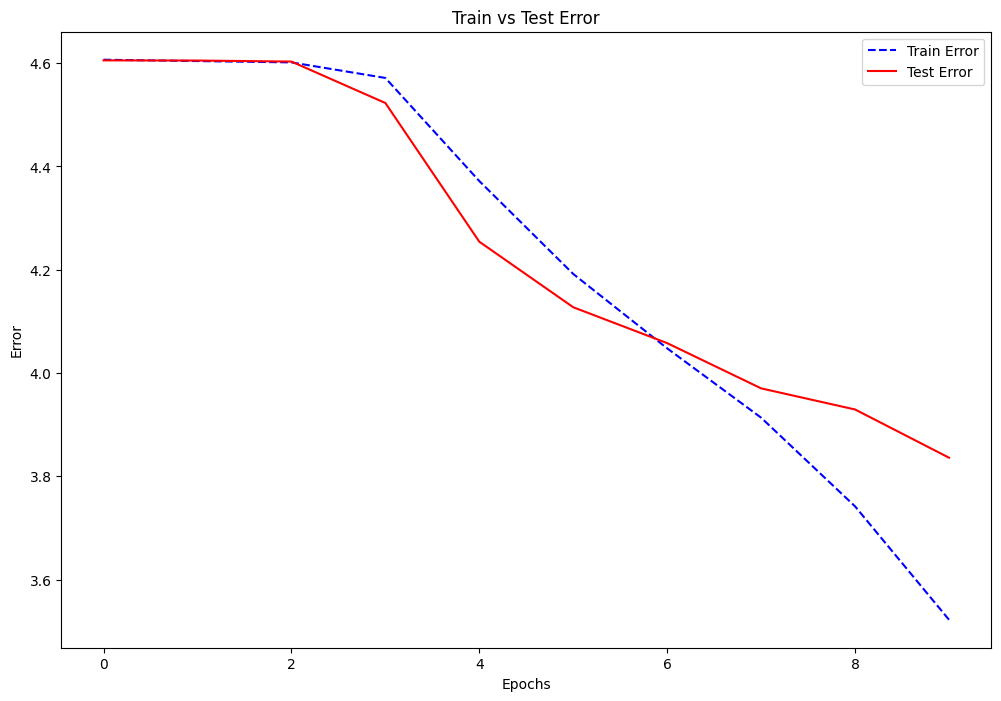


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.645105361938477
4.534852027893066
4.560169219970703
4.546825408935547
4.524205684661865
4.567270755767822
4.351554870605469
4.278214454650879
4.318796157836914
4.33135986328125
4.059219837188721
4.2686381340026855
4.364917755126953
4.177093029022217
4.461261749267578
4.22115421295166
4.175693511962891
4.371701240539551
4.055425643920898
4.085937976837158
4.011374473571777
4.144120693206787
4.240163803100586
3.824751138687134
4.132838249206543
█▄3.7889819145202637
3.7138936519622803
3.784419536590576
3.407353401184082
3.7248499393463135
4.195037364959717
3.488722324371338
3.8251326084136963
3.547659397125244
3.6105947494506836
3.912424087524414
3.41866135597229
3.8663523197174072
3.687605381011963
3.371201753616333
3.5164084434509277
3.3216090202331543
3.2942044734954834
3.462462902069092
3.1091816425323486
3.272360324859619
3.4689526557922363
2.8904714584350586
3.4627530574798584
3.5370161533355713
█▄2.879490375518799
3.207728624343872
2.8784327507019043
2.7852728366851807

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.35
Precision: 0.39
Recall: 0.35
F1 Score: 0.33




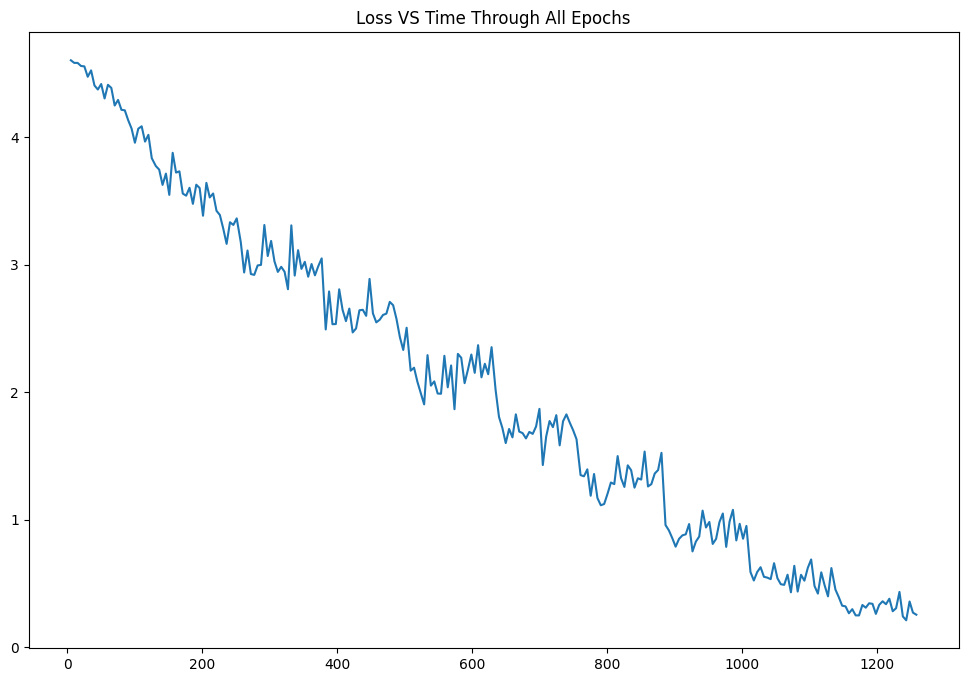

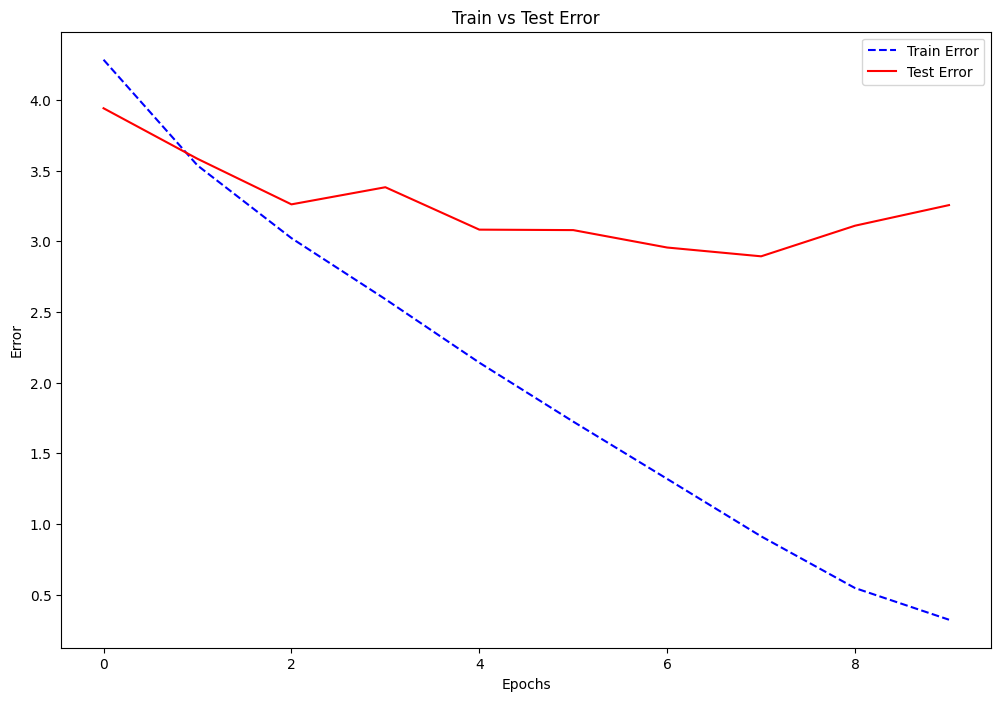


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.672059059143066
4.59482479095459
4.685380458831787
4.354659557342529
4.436656475067139
4.593265056610107
4.340259075164795
4.411675930023193
4.084389686584473
4.313418865203857
4.2390217781066895
4.436153411865234
4.111595153808594
4.243623733520508
4.204017639160156
4.126375198364258
4.101362228393555
3.8336305618286133
3.902390241622925
3.994476079940796
4.184451103210449
4.193017482757568
4.193221092224121
4.016286373138428
4.185307502746582
█▄3.545743227005005
3.775237560272217
3.853788375854492
3.515589714050293
3.365149974822998
3.4849443435668945
3.6296133995056152
3.542468786239624
3.604905128479004
3.8538036346435547
3.8639187812805176
3.382202625274658
3.719147205352783
3.3911662101745605
3.4893908500671387
3.328526496887207
3.5526719093322754
3.207279920578003
3.3740761280059814
3.198495388031006
3.2677931785583496
3.3727898597717285
2.9919142723083496
3.541478395462036
3.6402153968811035
█▄3.4995579719543457
2.8686728477478027
3.161306142807007
3.02907514572143

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.32
Precision: 0.33
Recall: 0.32
F1 Score: 0.30




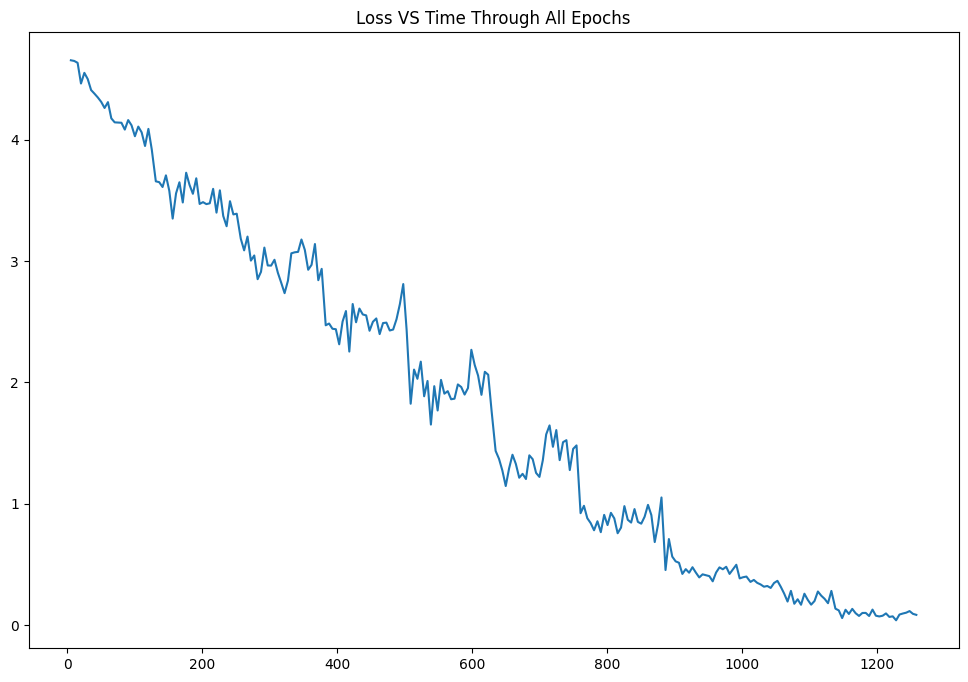

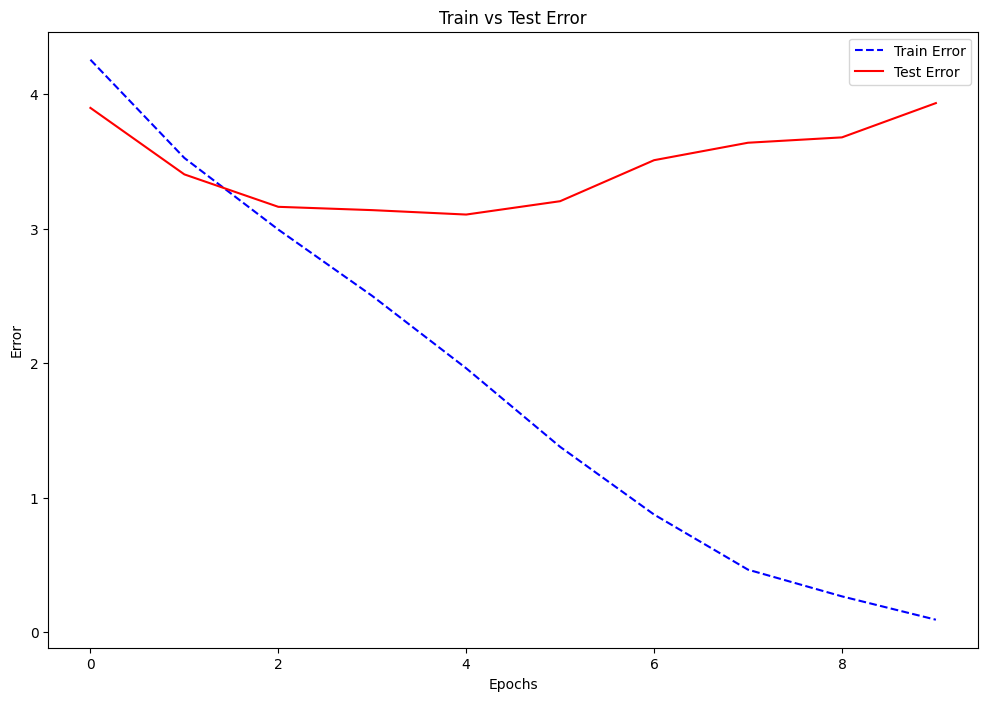


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.603375434875488
4.595879554748535
4.612705230712891
4.607153415679932
4.6036272048950195
4.604072570800781
4.6079254150390625
4.611420631408691
4.607415676116943
4.597758769989014
4.604393005371094
4.5966796875
4.605495929718018
4.608859062194824
4.6043596267700195
4.599559783935547
4.607550144195557
4.601136207580566
4.59143590927124
4.590539932250977
4.603030204772949
4.596621513366699
4.6045684814453125
4.614974021911621
4.60541296005249
█▄4.599519729614258
4.602237701416016
4.60575008392334
4.614592552185059
4.602779865264893
4.611639976501465
4.604142189025879
4.607397079467773
4.610644340515137
4.606961250305176
4.603213310241699
4.604475021362305
4.604476451873779
4.6010661125183105
4.597224235534668
4.59768533706665
4.594228744506836
4.604372978210449
4.610873699188232
4.605865478515625
4.597277641296387
4.606900215148926
4.599630355834961
4.611936569213867
4.595861434936523
█▄4.604405879974365
4.602080345153809
4.604413032531738
4.5915727615356445
4.58961248397827

### Results: 

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]
Accuracy: 0.11
Precision: 0.10
Recall: 0.11
F1 Score: 0.09




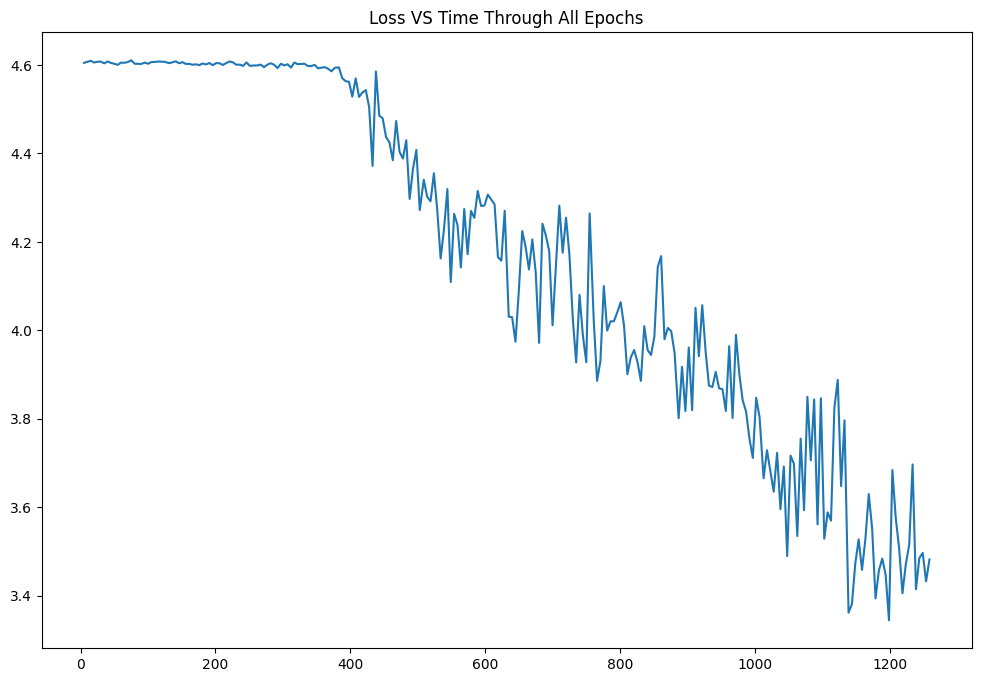

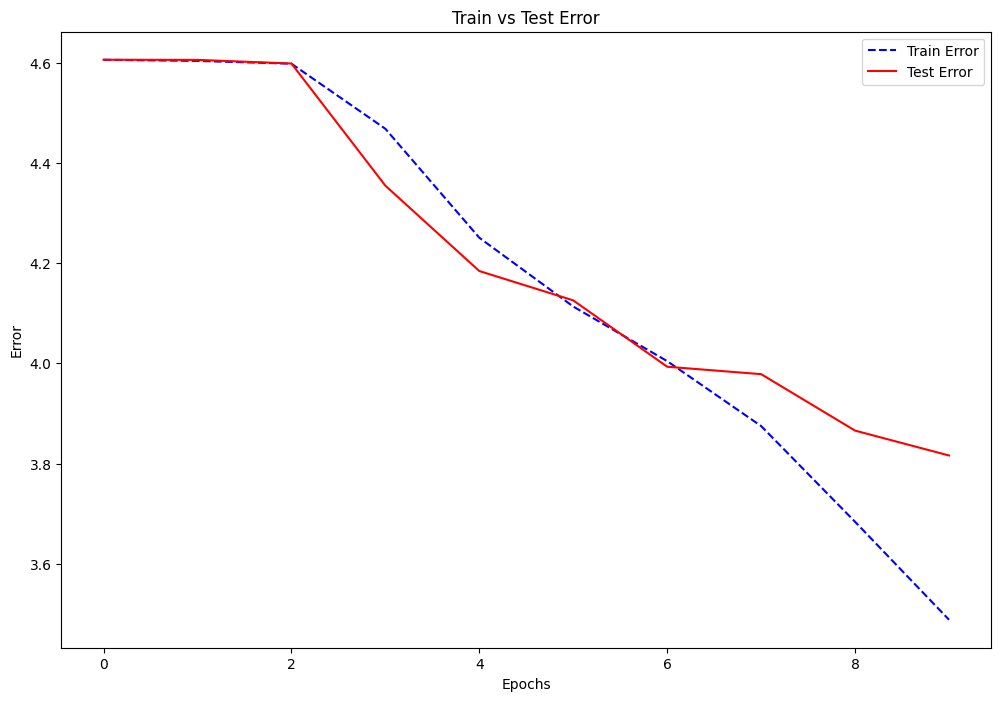


### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.698356628417969
4.679621696472168
4.605606555938721
4.608229637145996
4.523734092712402
4.446504592895508
4.487396717071533
4.153591632843018
4.316066741943359
4.210048675537109
4.246556758880615
4.408689498901367
4.198118209838867
4.1233601570129395
4.183345317840576
3.902982234954834
4.154029846191406
3.977107048034668
4.208111763000488
3.9316728115081787
3.983774185180664
4.172181129455566
3.904761791229248
3.949533700942993
3.496384382247925
█▄3.783710479736328
3.345045566558838
3.6488964557647705
3.2352752685546875
3.6815876960754395
3.6103687286376953
3.5289318561553955
3.7796552181243896
3.372206926345825
3.855532169342041
3.9577744007110596
3.332598924636841
3.520864486694336
3.5941925048828125
3.4695088863372803
3.339143991470337
3.3761491775512695
3.3522605895996094
3.4501731395721436
3.461967706680298
3.031214952468872
3.318624496459961
3.7656660079956055
2.8191609382629395
3.3660593032836914
█▄3.528393268585205
3.3234610557556152
2.6836395263671875
3.1814363002

### Results: 

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.36
Precision: 0.43
Recall: 0.36
F1 Score: 0.35




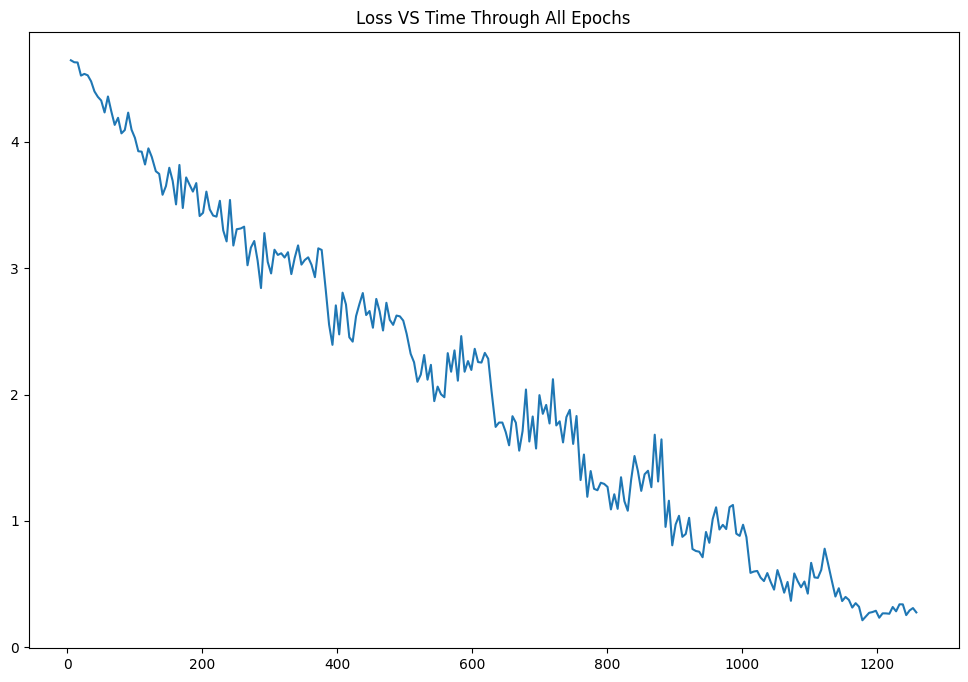

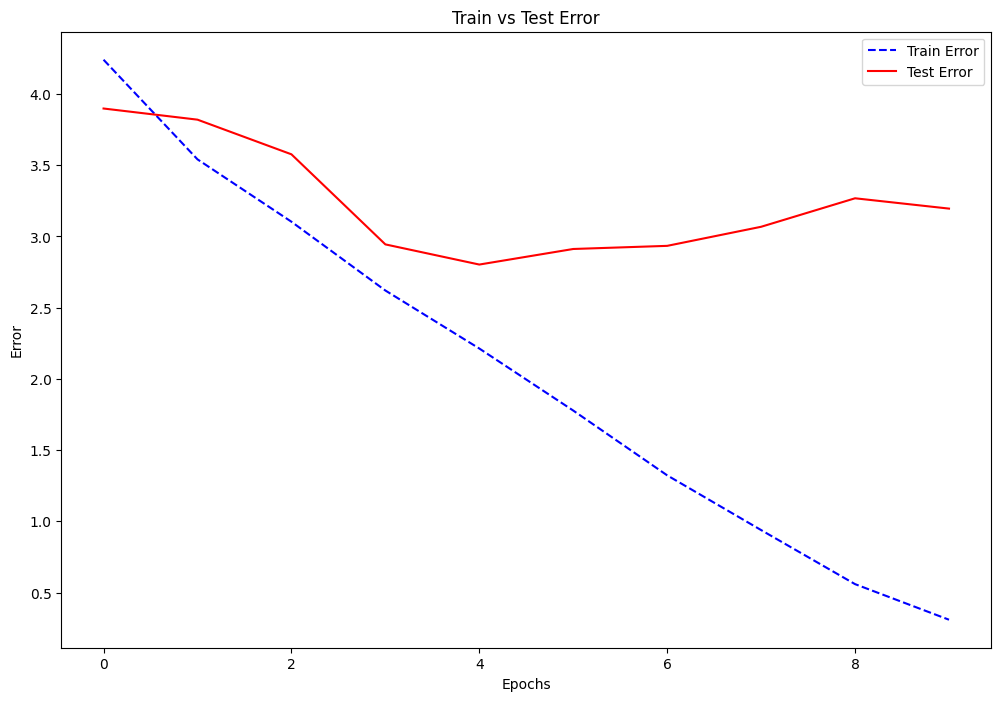


### Model Attributes:
- Type: CNNLES
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.643377780914307
4.777511119842529
4.592577934265137
4.625288963317871
4.291170597076416
4.383044242858887
4.366392135620117
4.514135837554932
4.311614036560059
4.307852745056152
4.181347370147705
4.146617412567139
4.303459167480469
3.9000205993652344
3.8028109073638916
4.349826335906982
3.770291566848755
4.134466648101807
3.93605899810791
4.069976806640625
3.830265998840332
3.7111992835998535
3.6159467697143555
3.9139816761016846
4.137206077575684
█▄3.937941551208496
3.4326632022857666
3.962773323059082
3.2694942951202393
3.515146255493164
3.548203468322754
3.1701745986938477
2.917201280593872
3.5468645095825195
3.4788286685943604
3.4584717750549316
3.682422637939453
3.06998348236084
3.5068564414978027
3.3504245281219482
3.240234375
3.611147165298462
3.795027494430542
3.4116039276123047
3.267510175704956
3.0975215435028076
3.275083303451538
3.831289768218994
3.6325883865356445
2.965893030166626
█▄3.590843677520752
3.06268048286438
3.054388999938965
3.2335379123687744
2.658

### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.29
Precision: 0.31
Recall: 0.29
F1 Score: 0.27




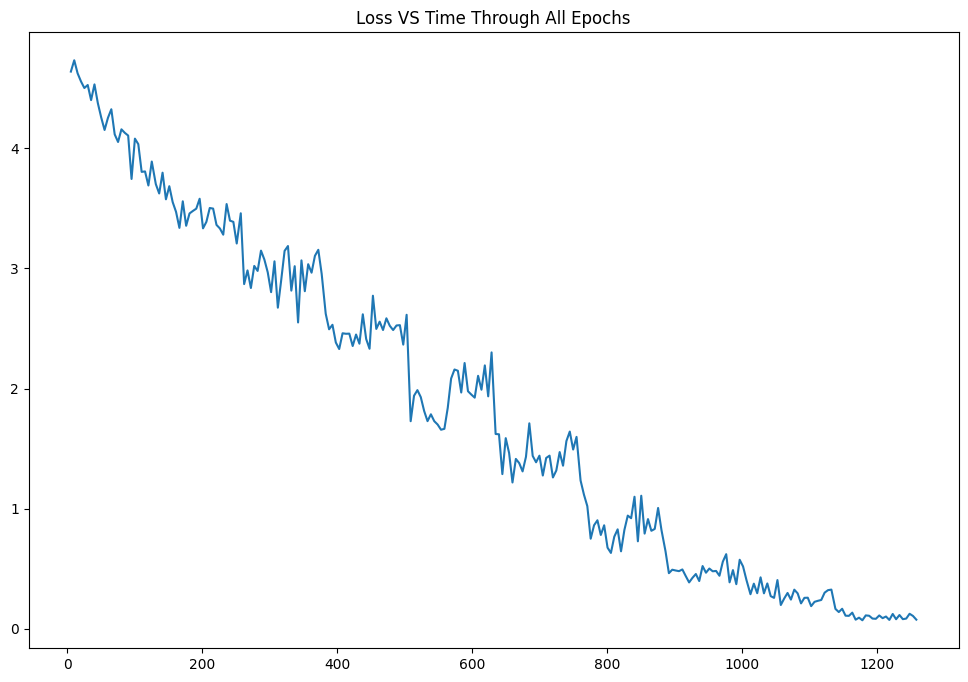

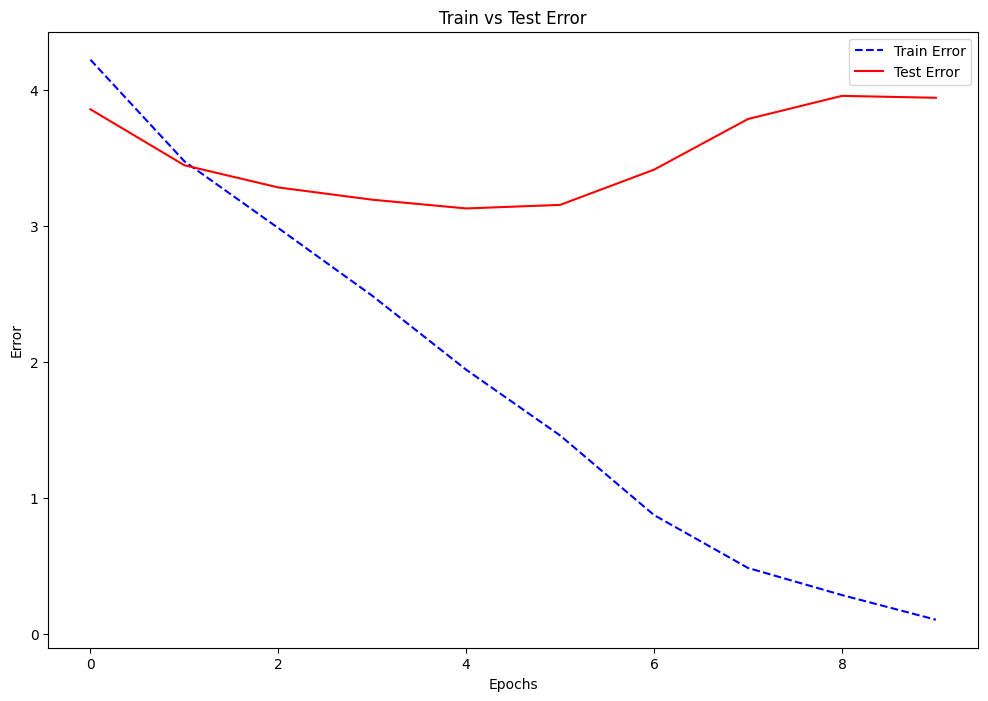


### Model Attributes:
- Type: noBNCNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.59809684753418
4.606928825378418
4.600324630737305
4.604811668395996
4.615809440612793
4.607004165649414
4.607367515563965
4.609443187713623
4.597322463989258
4.598719596862793
4.618370056152344
4.595973968505859
4.606322288513184
4.610000133514404
4.604388236999512
4.597145080566406
4.610536098480225
4.609797477722168
4.603030681610107
4.613656997680664
4.605071544647217
4.6076788902282715
4.610949993133545
4.613510608673096
4.60776424407959
█▄4.617824554443359
4.604618549346924
4.590441703796387
4.599193572998047
4.5948872566223145
4.596062660217285
4.596332550048828
4.601252555847168
4.610902786254883
4.60816764831543
4.611275672912598
4.6057868003845215
4.600431442260742
4.589450836181641
4.601929664611816
4.593746185302734
4.597402095794678
4.600910186767578
4.603814125061035
4.611495494842529
4.597681999206543
4.605769634246826
4.602540016174316
4.593319892883301
4.596686363220215
█▄4.624227523803711
4.587082386016846
4.5808868408203125
4.602216720581055
4.5880265235

### Results: 

Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.13
Precision: 0.10
Recall: 0.13
F1 Score: 0.10




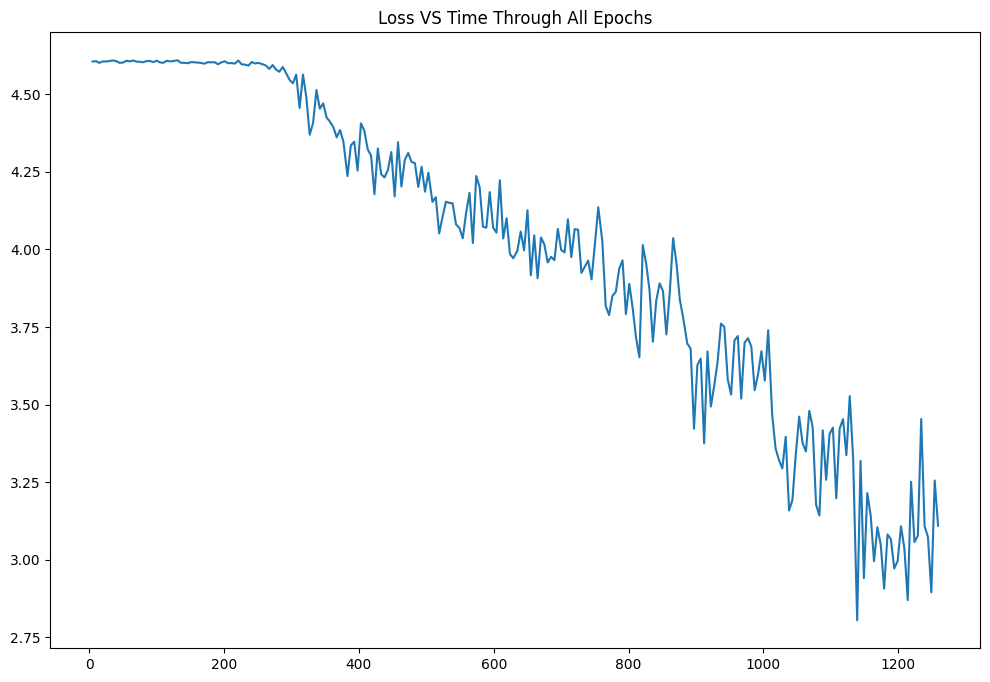

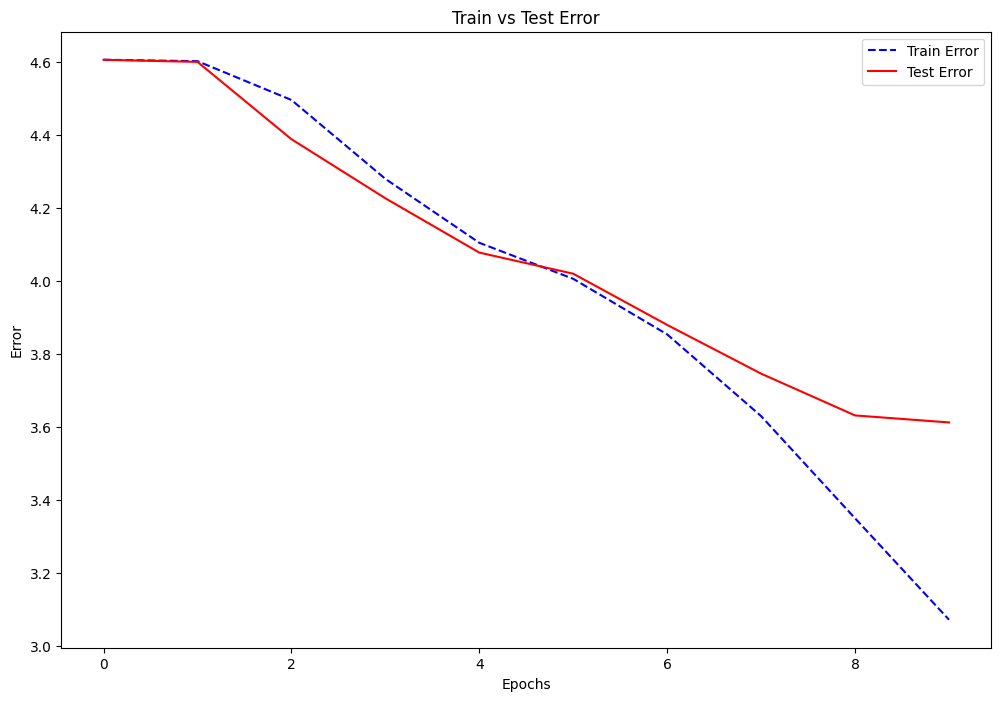

In [29]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 10
i = -1
batch_size = 32
lr = 0.005
activation = "Relu"
path = "smallDataset/"


CNNModels = []

for batch_size in [16, 32]:
    for n in [2, 4, 8, 12]:
        for typee in [CNN, CNNLES, noBNCNN]:
            text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
    """
            display(Markdown(text))

            model = typee(n).to(dml)

            transform = transformer

            metrics = train(model, lr, batch_size, transform, epoch_num, path)

            text = """### Results: """
            display(Markdown(text))

            finalMetrics = testModel(model, False, transform, path)
            plotTrainError(metrics[0], metrics[1])
            print()
            plotTrainTestError(epoch_num, metrics[2], metrics[3])

            i += 1

            modelDetails = [typee.__name__, batch_size, n, lr, activation]
            modelDetails.extend(finalMetrics)
            CNNModels.append(modelDetails)

In [34]:
pd.DataFrame(CNNModels)

,0,1,2,3,4,5,6,7,8
0,CNN,16,2,0.005,Relu,0.198,0.228,0.198,0.186
1,CNNLES,16,2,0.005,Relu,0.202,0.226,0.202,0.192
2,noBNCNN,16,2,0.005,Relu,0.090,0.090,0.090,0.077
3,CNN,16,4,0.005,Relu,0.240,0.293,0.240,0.236
4,CNNLES,16,4,0.005,Relu,0.202,0.219,0.202,0.178
5,noBNCNN,16,4,0.005,Relu,0.118,0.116,0.118,0.100
6,CNN,16,8,0.005,Relu,0.318,0.369,0.318,0.307
7,CNNLES,16,8,0.005,Relu,0.254,0.255,0.254,0.228
8,noBNCNN,16,8,0.005,Relu,0.140,0.135,0.140,0.118
9,CNN,16,12,0.005,Relu,0.316,0.353,0.316,0.293


In [30]:

typee = MLP


text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
    """
display(Markdown(text))

model = typee().to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(epoch_num, metrics[2], metrics[3])

i += 1

modelDetails = [typee.__name__, batch_size, n, lr, activation]
modelDetails.extend(finalMetrics)
CNNModels.append(modelDetails)


### Model Attributes:
- Type: MLP
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 10
    

Training..
4.598306179046631
4.583438873291016
4.599203109741211
4.602093696594238
4.570701599121094
4.545941352844238
4.5634050369262695
4.509622097015381
4.524440765380859
4.511440277099609
4.549525737762451
4.533061504364014
4.462173938751221
4.5290656089782715
4.48310661315918
4.495579242706299
4.514073848724365
4.463684558868408
4.52776575088501
4.546906471252441
4.417473793029785
4.442963123321533
4.465721130371094
4.438998222351074
4.444694519042969
█▄4.33906364440918
4.308023452758789
4.359307289123535
4.315640926361084
4.303305625915527
4.42179012298584
4.37839412689209
4.258178234100342
4.445892333984375
4.294660568237305
4.370334625244141
4.379704475402832
4.319602012634277
4.3409929275512695
4.283634185791016
4.276308059692383
4.26992654800415
4.367520809173584
4.407566070556641
4.37562370300293
4.337268352508545
4.33355188369751
4.316690444946289
4.370544910430908
4.334464073181152
█▄4.281954288482666
4.214263439178467
4.18440055847168
4.201777935028076
4.26494836807251
4.

KeyboardInterrupt: 


## Modeling



### Model Attributes:
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 64
- Epoch Count: 10
    

Training..
0.385794997215271
0.5979694128036499
0.613614559173584
0.7676504850387573
0.48494037985801697
0.6023379564285278
0.7173100113868713
0.3774344325065613
0.5812312364578247
0.6161162853240967
0.940677285194397
0.6114453077316284
0.6713181138038635
0.754165768623352
0.9125046730041504
0.6802774667739868
0.5740056037902832
0.9114260673522949
0.6202961206436157
0.70118248462677
0.633064866065979
0.622529923915863
0.6737473607063293
0.6567723751068115
1.1652406454086304
1.012664794921875
0.9542831182479858
0.5236753821372986
0.6032626628875732
0.5600595474243164
0.6976082921028137
0.8285281658172607
0.7491236329078674
0.796842634677887
0.992241382598877
0.7411435842514038
0.763435959815979
1.0216550827026367
1.0440449714660645
0.6753522157669067
0.8798010349273682
1.040528655052185
█▄0.554724931716919
0.6964166164398193
0.36009207367897034
0.4797055423259735
0.5202192068099976
0.37519603967666626
0.42170023918151855
0.5482803583145142
0.5175557136535645
0.6630139946937561
0.7585059

### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.60
Precision: 0.64
Recall: 0.60
F1 Score: 0.59




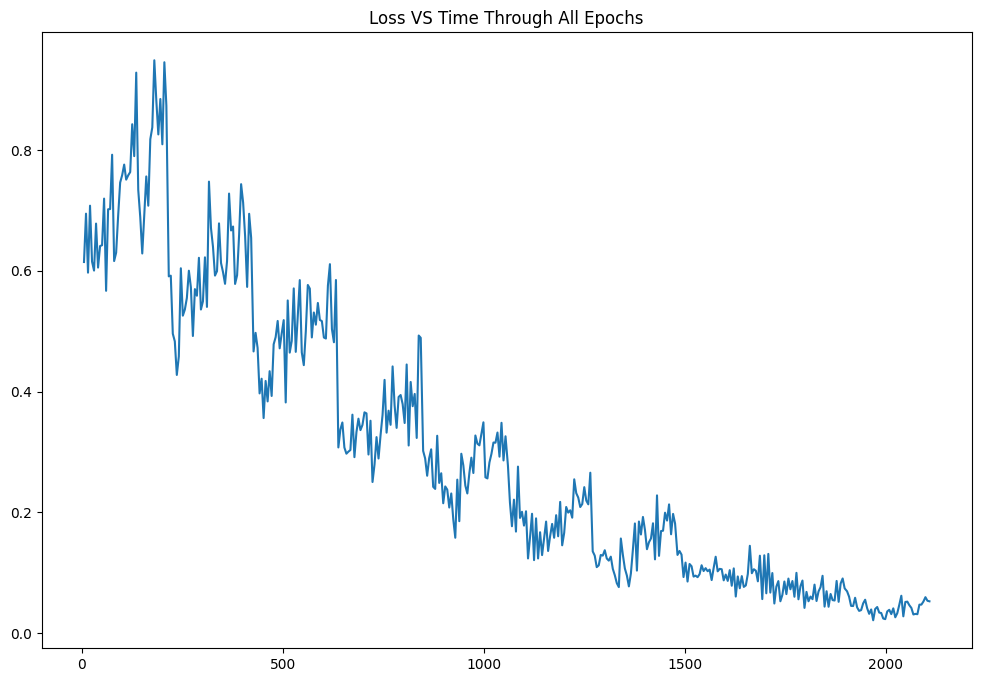

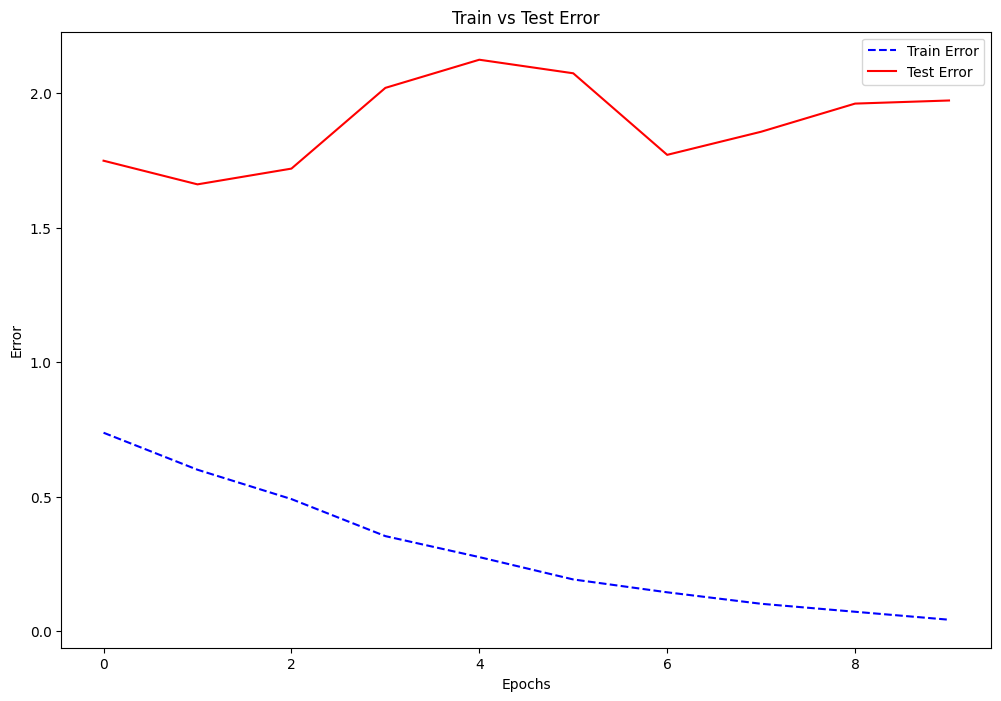

In [15]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 10
i = -1
batch_size = 64
lr = 0.005
activation = "Relu"
path = "dataset/"


CNNModels = []

text = f"""
### Model Attributes:
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
    """
display(Markdown(text))

#model = CNN().to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(epoch_num, metrics[2], metrics[3])